# Imports

In [1]:
import os
import sys
import pysam
import pickle
import random
import modisco
import warnings
import plotnine
import pybedtools
import numpy as np
import tabix as tb
import pandas as pd
from plotnine import *
from pandas import Series
from decimal import Decimal
from kerasAC.splits import *
from matplotlib import pyplot as plt
from deeplift.dinuc_shuffle import dinuc_shuffle

from dragonn.interpret import * 
from dragonn.vis import *
from dragonn.utils import *

sys.path.insert(0, "/users/soumyak/alzheimers_parkinsons/clusters_gkmsvm")
from viz_preprocess import *
from viz_sequence import *

np.random.seed(1234)
plt.style.use('default')
pd.set_option('display.max_columns', None)

TF-MoDISco is using the TensorFlow backend.
Using TensorFlow backend.


# Quick Links

<ol>
    <li><a href=#effect_table>Effect Alleles Table</a></li>
    <li><a href=#effect_viz>Effect Alleles Visual</a></li>
    <li><a href=#noneffect_table>Non-Effect Alleles Table</a></li>
    <li><a href=#noneffect_viz>Non-Effect Alleles Visual</a></li>
</ol>

# Cluster 14

In [2]:
cluster = '14'

## Prepare Effect and Non-Effect Scores

In [3]:
effect_fasta = '/mnt/lab_data3/soumyak/adpd/fasta_inputs/Cluster'+cluster+'.effect.fasta'
effect_seqs = [x.rstrip() for (i,x) in enumerate(open(effect_fasta)) if i%2==1]
effect_onehot = [np.array(one_hot_encode_along_channel_axis(x)) for x in effect_seqs]

print("Num effect sequences:", len(effect_onehot))

merged_effect_scores = np.zeros(shape=(len(effect_onehot), 1000, 4))

for fold in range(10):
    effect_file = '/mnt/lab_data3/soumyak/adpd/explain_scores/Cluster'+cluster+'/fold'+str(fold)+'.effect.scores.txt'
    effect_scores = get_hyp_scores(effect_file, effect_seqs)
    effect_scores = np.array(effect_scores)
    merged_effect_scores = merged_effect_scores + effect_scores
    
merged_effect_scores = merged_effect_scores / (fold + 1)

#--------------------------------------------------------#

noneffect_fasta = '/mnt/lab_data3/soumyak/adpd/fasta_inputs/Cluster'+cluster+'.noneffect.fasta'
noneffect_seqs = [x.rstrip() for (i,x) in enumerate(open(noneffect_fasta)) if i%2==1]
noneffect_onehot = [np.array(one_hot_encode_along_channel_axis(x)) for x in noneffect_seqs]

print("Num noneffect sequences:", len(noneffect_onehot))

merged_noneffect_scores = np.zeros(shape=(len(noneffect_onehot), 1000, 4))

for fold in range(10):
    noneffect_file = '/mnt/lab_data3/soumyak/adpd/explain_scores/Cluster'+cluster+'/fold'+str(fold)+'.noneffect.scores.txt'
    noneffect_scores = get_hyp_scores(noneffect_file, noneffect_seqs)
    noneffect_scores = np.array(noneffect_scores)
    merged_noneffect_scores = merged_noneffect_scores + noneffect_scores
    
merged_noneffect_scores = merged_noneffect_scores / (fold + 1)

#--------------------------------------------------------#

merged_ism_scores = np.zeros(shape=(len(effect_onehot),))
merged_delta_scores = np.zeros(shape=(len(effect_onehot),))

for fold in range(10):
    ism_scores = np.array([float(i.strip().split('\t')[1]) for i in open('/mnt/lab_data3/soumyak/adpd/ism_scores/Cluster'+cluster+'/fold'+str(fold)+'.ism.scores').readlines()])
    delta_scores = np.array([float(i.strip().split('\t')[1]) for i in open('/mnt/lab_data3/soumyak/adpd/delta_scores/Cluster'+cluster+'/fold'+str(fold)+'.delta.scores').readlines()])
    merged_ism_scores = merged_ism_scores + ism_scores
    merged_delta_scores = merged_delta_scores + delta_scores
        
merged_ism_scores = merged_ism_scores / (fold + 1)
merged_delta_scores = merged_delta_scores / (fold + 1)

Num effect sequences: 435
Num noneffect sequences: 435


## Prepare DataFrame

In [4]:
snps = pd.read_csv('/mnt/lab_data3/soumyak/adpd/snp_lists/Cluster'+cluster+'.overlap.expanded.snps.hg38.bed', sep='\t')
ryan_snps = pd.read_csv('/oak/stanford/groups/akundaje/projects/alzheimers_parkinsons/snps_final/191023_All_GWAS_SNPs_unique.csv', sep='\t')
mike_snps = pd.read_csv('/oak/stanford/groups/akundaje/projects/alzheimers_parkinsons/snps_final/ld_buddies_table_stage3.tsv', sep='\t')
effect_score = []
noneffect_score = []
effect_center = []
noneffect_center = []
effect_ratio = []
noneffect_ratio = []
allele_ratio = []
allele_diff = []
effect_rank = []
noneffect_rank = []
ism_score = []
delta_score = []
idr_peak = []
all_gwas = []
coloc = []
for index,row in snps.iterrows():
    effect_score.append(np.sum(np.array([np.sum(j) for j in merged_effect_scores[index][400:600]])))
    noneffect_score.append(np.sum(np.array([np.sum(j) for j in merged_noneffect_scores[index][400:600]])))
    effect_center.append(np.sum(np.array([max(0, np.sum(j)) for j in merged_effect_scores[index][475:525]])))
    noneffect_center.append(np.sum(np.array([max(0, np.sum(j)) for j in merged_noneffect_scores[index][475:525]])))
    effect_ratio.append(np.sum(np.array([max(0, np.sum(j)) for j in merged_effect_scores[index][475:525]])) / np.sum(np.array([max(0, np.sum(j)) for j in merged_effect_scores[index][400:600]])))
    noneffect_ratio.append(np.sum(np.array([max(0, np.sum(j)) for j in merged_noneffect_scores[index][475:525]])) / np.sum(np.array([max(0, np.sum(j)) for j in merged_noneffect_scores[index][400:600]])))
    allele_ratio.append(effect_center[-1] / (noneffect_center[-1] + 0.00001))
    #allele_diff.append(effect_center[-1] - noneffect_center[-1])
    allele_diff.append(np.sum(np.array([np.sum(j) for j in merged_effect_scores[index][475:525]])) - np.sum(np.array([np.sum(j) for j in merged_noneffect_scores[index][475:525]])))
    effect_rank.append((effect_center[-1] / (noneffect_center[-1] + 0.00001)) * effect_ratio[-1])
    noneffect_rank.append((noneffect_center[-1] / (effect_center[-1] + 0.00001)) * noneffect_ratio[-1])
    idr_peak_overlap = False
    for ind,rw in ryan_snps.loc[ryan_snps['rsid']==row['rsid']].iterrows():
        if rw['Cluster'+cluster+'_overlap'] == 1:
            idr_peak_overlap = True
    idr_peak.append(idr_peak_overlap)
    gwas_list = []
    has_coloc = False
    for ind,rw in mike_snps.loc[mike_snps['rsid']==row['rsid']].iterrows():
        gwas_list.append(rw['source_gwas']+': '+str('%.2E' % Decimal(rw['pvalue'])))
        if rw['has_coloc'] == True:
            has_coloc = True
    all_gwas.append(gwas_list)
    coloc.append(has_coloc)
snps['effect_score'] = effect_score
snps['noneffect_score'] = noneffect_score
snps['effect_center'] = effect_center
snps['noneffect_center'] = noneffect_center
snps['effect_ratio'] = effect_ratio
snps['noneffect_ratio'] = noneffect_ratio
snps['allele_ratio'] = allele_ratio
snps['allele_diff'] = allele_diff
snps['effect_rank'] = effect_rank
snps['noneffect_rank'] = noneffect_rank
snps['ism_score'] = merged_ism_scores
snps['delta_score'] = merged_delta_scores
snps['idr_peak'] = idr_peak
snps['all_gwas'] = all_gwas
snps['coloc'] = coloc
snps.sort_values(by=['allele_ratio'], ascending=True, inplace=True)
snps.drop_duplicates(subset=['rsid'], inplace=True)

## Find Effect Alleles that Break Accessibility <a name='effect_table' />

In [5]:
neg_snps = snps.loc[snps['allele_ratio'] <= 1]
neg_snps.sort_values(by=['noneffect_rank'], ascending=False, inplace=True)
display(neg_snps)

chr      start        end         rsid effect noneffect ref  alt major  \
375   chr4   89829436   89829437    rs2583979      T         A   A    T     T   
273  chr19   45326535   45326536     rs344791      C         G   G    C     C   
303   chr2  127128581  127128582   rs13025717      T         C   C    T     C   
387   chr4   89837895   89837896    rs2619363    NAN       NAN   G  C,T     G   
274   chr2   95057163   95057164     rs872580      C         A   C    A     A   
216  chr19   44644418   44644419   rs10426401      T         G   T    G     T   
398   chr5  103120549  103120550      rs26523      T         C   C    T     C   
218  chr19   44721571   44721572    rs4802235      T         G   G  A,T     G   
54   chr15   58758182   58758183    rs2250583      C         T   C    T     T   
221  chr19   44747898   44747899    rs2965169      C         A   A    C     C   
349   chr3  183006617  183006618    rs6791884      G         A   A    G     G   
230  chr19   44846144   44846145    rs3810143      C         T   T  C,G     T   
343   chr3   52712648   52712649  rs150322055      G         C   G  A,C     G   
11   chr10   15515276   15515277     rs896434      T         G   T    G     G   
135  chr17   45942947   45942948   rs62062772      T         C   C    T     C   
317  chr21   37453051   37453052   rs10854381      C         A   A    C     A   
283   chr2  101736882  101736883    rs7569049      T         G   T    G     T   
201  chr17   78426790   78426791   rs72914885      C         A   A    C     A   
118  chr17   45894418   45894419   rs11575895      G         A   A    G     A   
323   chr3   49007333   49007334    rs6781790      T         C   C    T     T   
340   chr3   52557247   52557248  rs151215721      G         A   G    A     G   
93   chr17    4908319    4908320    rs7214776      T         C   T    C     T   
28   chr11   86068119   86068120    rs2509609      C         G   C  A,G     G   
120  chr17   45894775   45894776   rs11575896      G         A   G    A     G   
106  chr17   45815417   45815418   rs55915917      T         G   T    G     T   
121  chr17   45895214   45895215   rs74457229      T         C   C    T     C   
402   chr6   27754284   27754285    rs4713121      T         C   T    C     T   
87   chr17    4901871    4901872   rs79436576      T         C   C    T     C   
196  chr17   75078919   75078920  rs117223601      A         G   G    A     G   
390   chr5  102971887  102971888    rs6881225      T         C   T    C     T   
..     ...        ...        ...          ...    ...       ...  ..  ...   ...   
309   chr2  134719264  134719265   rs62171395      G         C   C    G     C   
146  chr17   45955548   45955549   rs17571739      T         C   T    C     T   
235  chr19   44891078   44891079   rs71352238      C         T   T    C     T   
75   chr16   70676645   70676646   rs11647479      A         C   A    C     A   
293   chr2  127094444  127094445  2_127094445    NAN       NAN   .    .     .   
373   chr4   89766355   89766356    rs3796661      T         C   C    T     C   
409   chr7   23106492   23106493    rs2072368      T         C   C    T     C   
13   chr10   80491787   80491788    rs7922621      A         C   C    A     A   
348   chr3  161372827  161372828    rs2054710      T         C   C  G,T     C   
94   chr17    4909107    4909108   rs16954243      A         T   A    T     A   
327   chr3   52193257   52193258  rs141535281      T         C   C  A,T     C   
150  chr17   45974221   45974222  rs117124984      G         C   C    G     C   
302   chr2  127107527  127107528  2_127107528    NAN       NAN   .    .     .   
346   chr3  151372635  151372636    rs3732765      G         A   G    A     G   
113  chr17   45858521   45858522   rs55996632      T         C   C    T     C   
96   chr17    5111493    5111494   rs56229705      A         G   G  A,C     G   
163  chr17   46024196   46024197       rs9468      T         C   T    C     T   
399   chr5  103120599  103120600      

## Visualize Top Effect Alleles <a name='effect_viz' />

RSID: rs2583979   ||    chr4 : 89829436 - 89829437   ||    Locus: 375   ||    IDR Peak: False

GWAS:
Parkinsons_Pankratz_2012 	  NAN
23andme_PD_hg38 		  3.63E-14

Coloc:  True

Noneffect Allele : A   ||   Explain Score : 0.4131   ||   Center / 200bp : 0.5305
Noneffect Sequence : TTTTCAGCAACACTTCCTCT


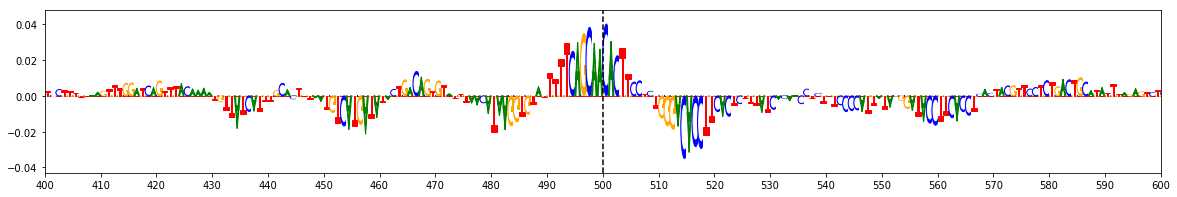

Effect Allele : T   ||   Explain Score : 0.1009   ||   Center / 200bp : 0.2166
Effect Sequence : TTTTCAGCATCACTTCCTCT


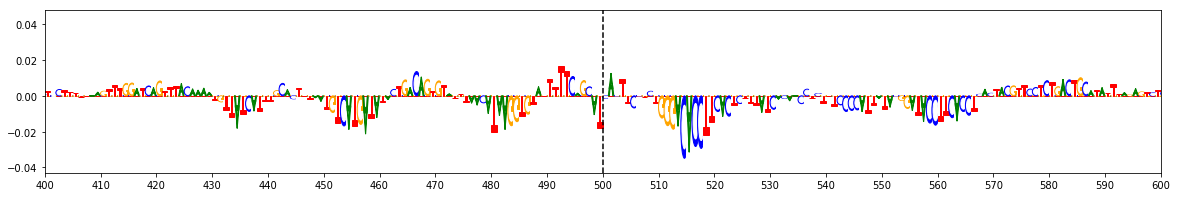

Allele Ratio : 0.2442   ||   Allele Difference : -0.3501  ||  ISM Score : -0.5518  ||  deltaSVM Score : -3.1546


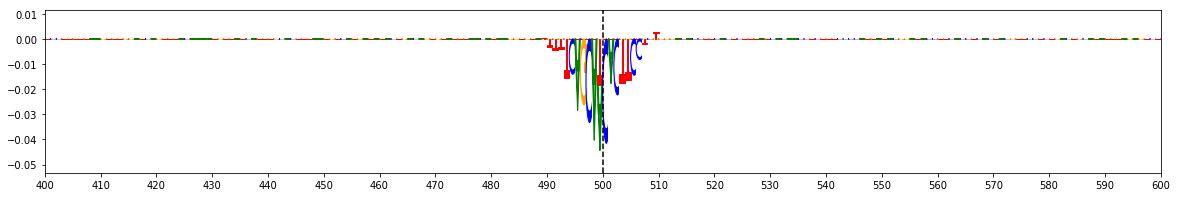


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs344791   ||    chr19 : 45326535 - 45326536   ||    Locus: 273   ||    IDR Peak: True

GWAS:
Alzheimers_Jansen_2018 		  1.22E-04

Coloc:  True

Noneffect Allele : G   ||   Explain Score : 0.3715   ||   Center / 200bp : 0.4498
Noneffect Sequence : CTCAAGACCGCCTCCACTGT


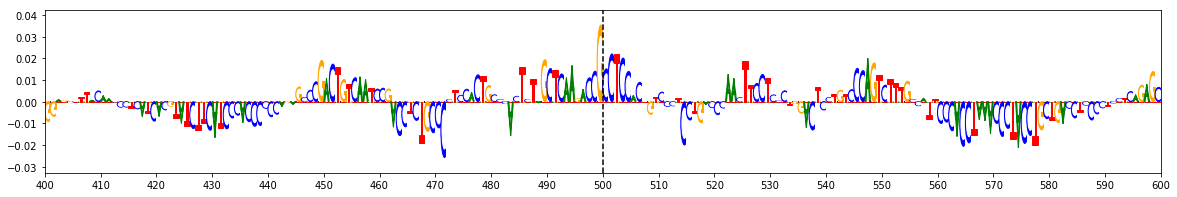

Effect Allele : C   ||   Explain Score : 0.1453   ||   Center / 200bp : 0.2443
Effect Sequence : CTCAAGACCCCCTCCACTGT


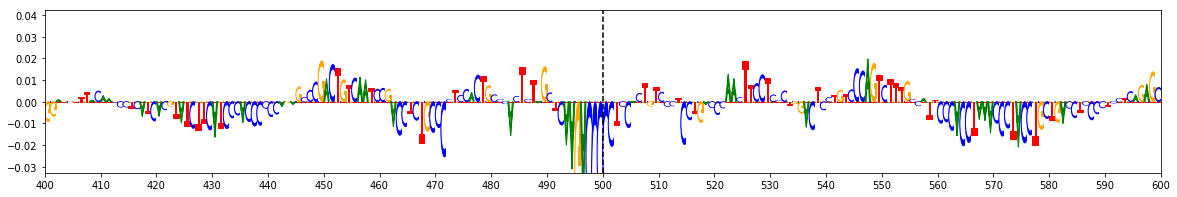

Allele Ratio : 0.3911   ||   Allele Difference : -0.6588  ||  ISM Score : -1.0477  ||  deltaSVM Score : -6.0325


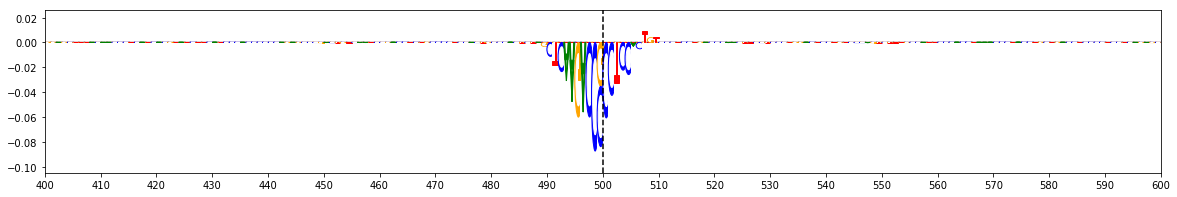


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs13025717   ||    chr2 : 127128581 - 127128582   ||    Locus: 303   ||    IDR Peak: False

GWAS:
Alzheimers_Jansen_2018 		  9.13E-17
Alzheimers_Kunkle_2019 		  2.98E-15
Alzheimers_Lambert_2013 	  7.94E-13

Coloc:  False

Noneffect Allele : C   ||   Explain Score : 1.0647   ||   Center / 200bp : 0.4239
Noneffect Sequence : CAGAAGCCCCGCCCAATGAG


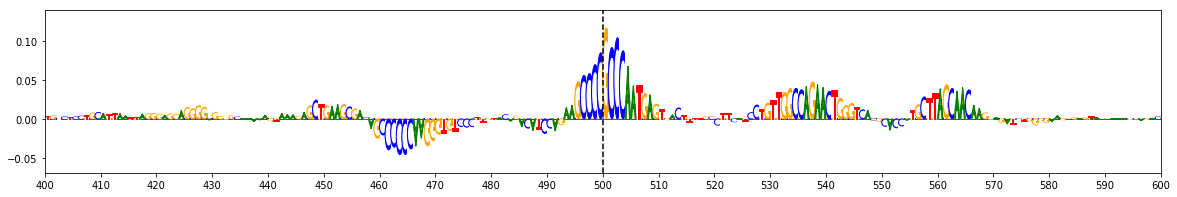

Effect Allele : T   ||   Explain Score : 0.4414   ||   Center / 200bp : 0.2339
Effect Sequence : CAGAAGCCCTGCCCAATGAG


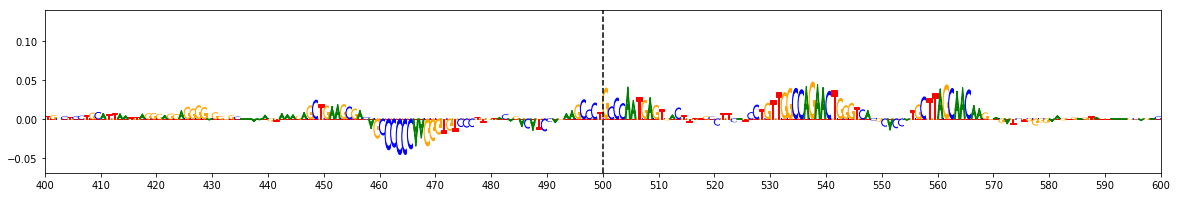

Allele Ratio : 0.4146   ||   Allele Difference : -0.5934  ||  ISM Score : -0.9251  ||  deltaSVM Score : -5.2106


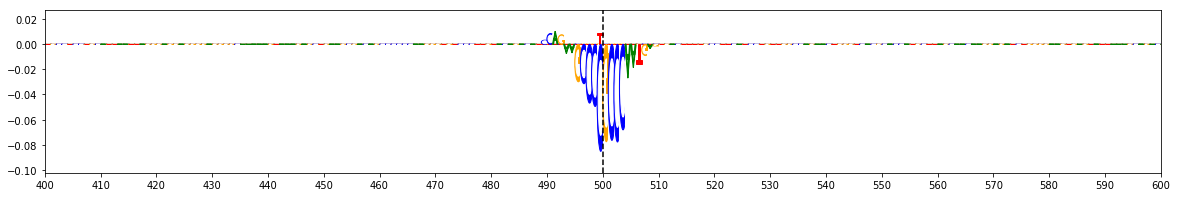


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs2619363   ||    chr4 : 89837895 - 89837896   ||    Locus: 387   ||    IDR Peak: True

GWAS:
Parkinsons_Pankratz_2012 	  NAN
23andme_PD_hg38 		  1.43E-08

Coloc:  True

Noneffect Allele : NAN   ||   Explain Score : 1.2185   ||   Center / 200bp : 0.614
Noneffect Sequence : CCAATCAGCGCCTGCCAGAC


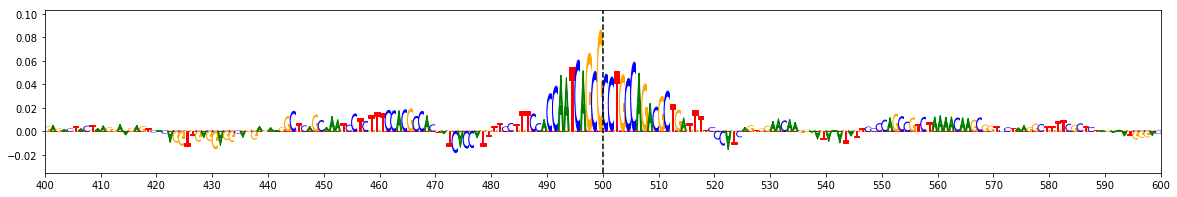

Effect Allele : NAN   ||   Explain Score : 0.7723   ||   Center / 200bp : 0.5
Effect Sequence : CCAATCAGCCCCTGCCAGAC


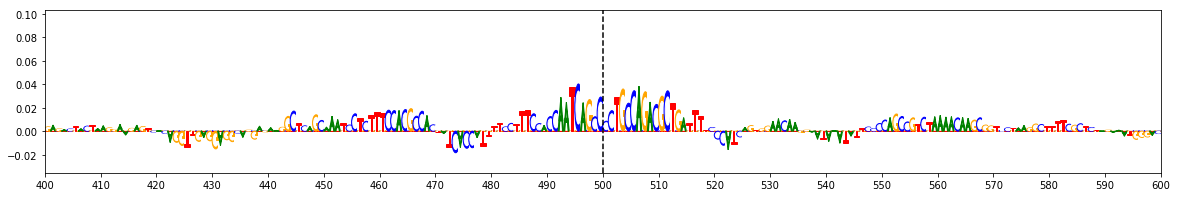

Allele Ratio : 0.6338   ||   Allele Difference : -0.447  ||  ISM Score : -0.6712  ||  deltaSVM Score : -4.1252


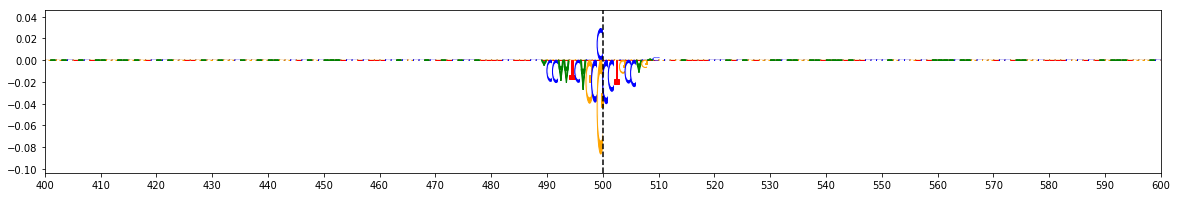


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs872580   ||    chr2 : 95057163 - 95057164   ||    Locus: 274   ||    IDR Peak: False

GWAS:
Nalls_23andMe 		  4.04E-02

Coloc:  False

Noneffect Allele : A   ||   Explain Score : 0.8412   ||   Center / 200bp : 0.4339
Noneffect Sequence : TTCCATGGCACTCGAGCAGC


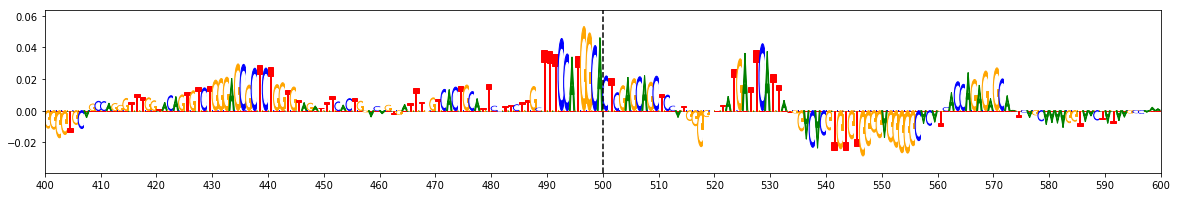

Effect Allele : C   ||   Explain Score : 0.3795   ||   Center / 200bp : 0.257
Effect Sequence : TTCCATGGCCCTCGAGCAGC


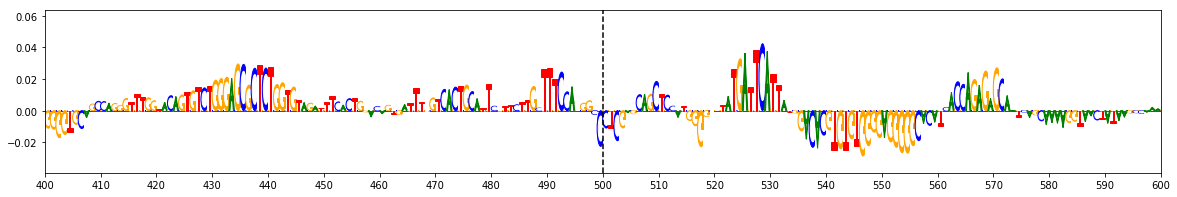

Allele Ratio : 0.4511   ||   Allele Difference : -0.5423  ||  ISM Score : -0.8413  ||  deltaSVM Score : -4.9073


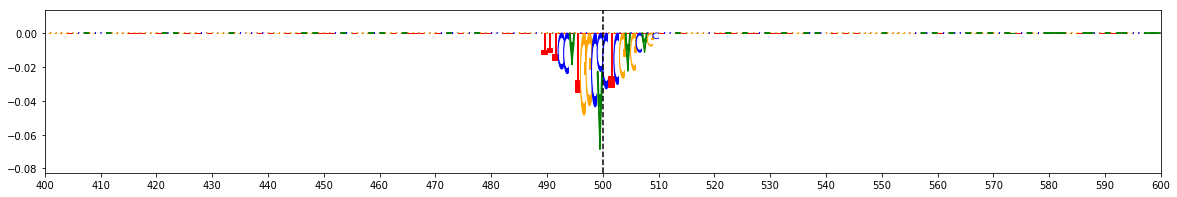


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs10426401   ||    chr19 : 44644418 - 44644419   ||    Locus: 216   ||    IDR Peak: True

GWAS:
Alzheimers_Jansen_2018 		  4.63E-14
Alzheimers_Kunkle_2019 		  5.66E-11
Alzheimers_Lambert_2013 	  2.79E-09

Coloc:  True

Noneffect Allele : G   ||   Explain Score : 1.2428   ||   Center / 200bp : 0.6193
Noneffect Sequence : CAACACGGGGCGGGCACAAG


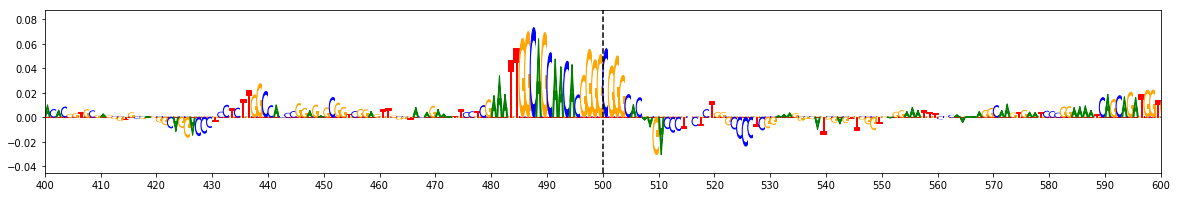

Effect Allele : T   ||   Explain Score : 0.8029   ||   Center / 200bp : 0.512
Effect Sequence : CAACACGGGTCGGGCACAAG


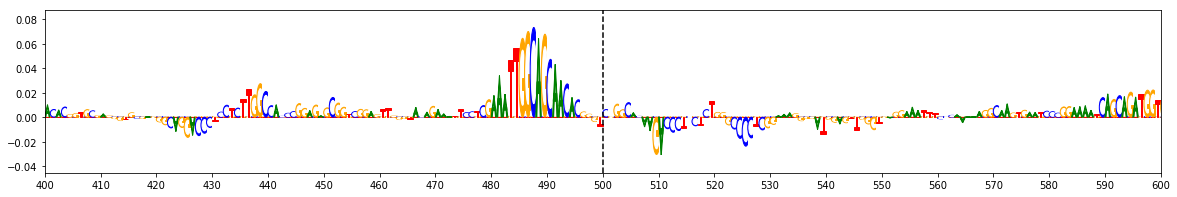

Allele Ratio : 0.646   ||   Allele Difference : -0.4598  ||  ISM Score : -0.7355  ||  deltaSVM Score : -4.2157


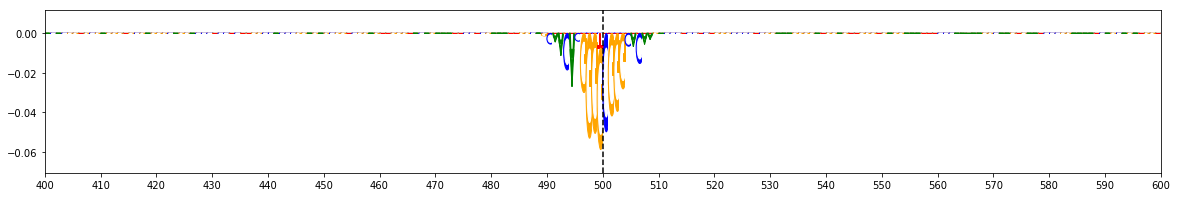


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs26523   ||    chr5 : 103120549 - 103120550   ||    Locus: 398   ||    IDR Peak: True

GWAS:
Nalls_23andMe 		  1.08E-03

Coloc:  False

Noneffect Allele : C   ||   Explain Score : 0.8954   ||   Center / 200bp : 0.5559
Noneffect Sequence : GGGTTGAGGCGGCTGCTGGG


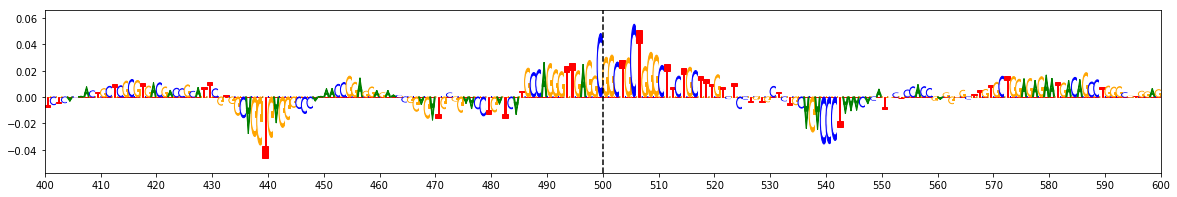

Effect Allele : T   ||   Explain Score : 0.5197   ||   Center / 200bp : 0.421
Effect Sequence : GGGTTGAGGTGGCTGCTGGG


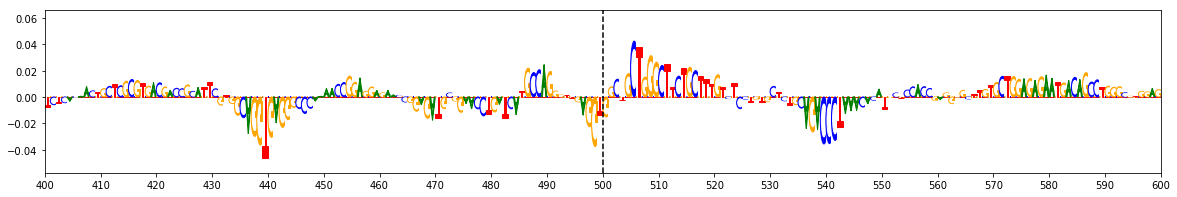

Allele Ratio : 0.5805   ||   Allele Difference : -0.4853  ||  ISM Score : -0.7577  ||  deltaSVM Score : -4.3868


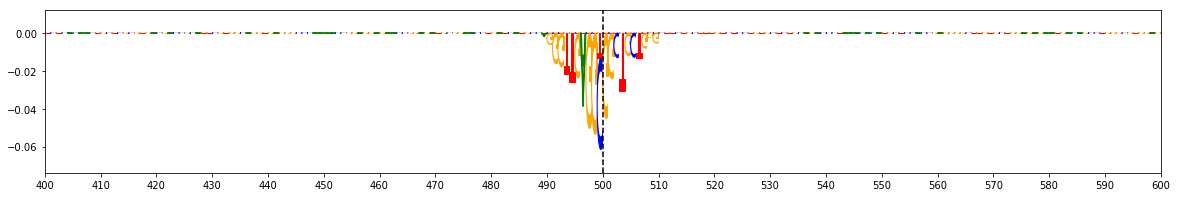


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs4802235   ||    chr19 : 44721571 - 44721572   ||    Locus: 218   ||    IDR Peak: False

GWAS:
Alzheimers_Kunkle_2019 		  1.05E-13
Alzheimers_Lambert_2013 	  6.86E-09

Coloc:  True

Noneffect Allele : G   ||   Explain Score : 1.5411   ||   Center / 200bp : 0.6466
Noneffect Sequence : TGCAGTGGCGCAATCTCGGC


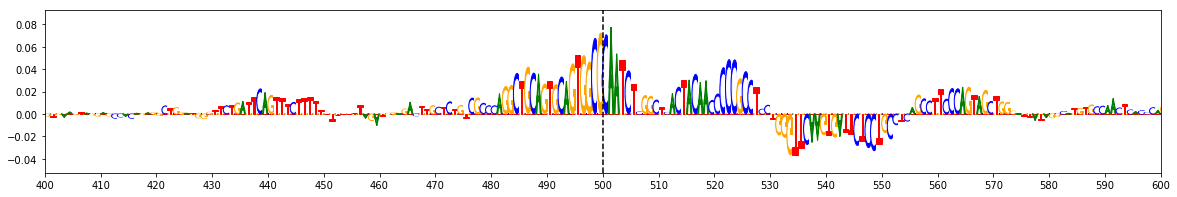

Effect Allele : T   ||   Explain Score : 1.0518   ||   Center / 200bp : 0.5551
Effect Sequence : TGCAGTGGCTCAATCTCGGC


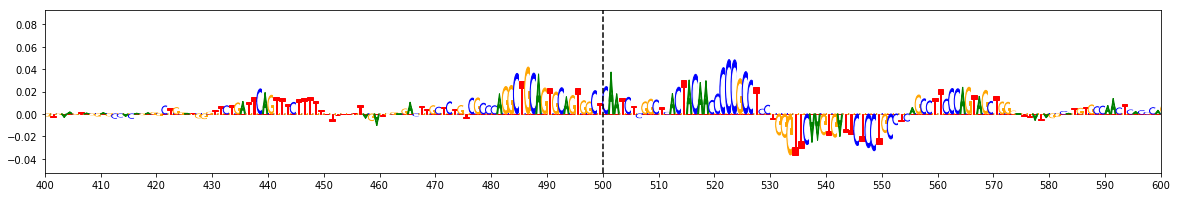

Allele Ratio : 0.6825   ||   Allele Difference : -0.4926  ||  ISM Score : -0.8321  ||  deltaSVM Score : -4.7968


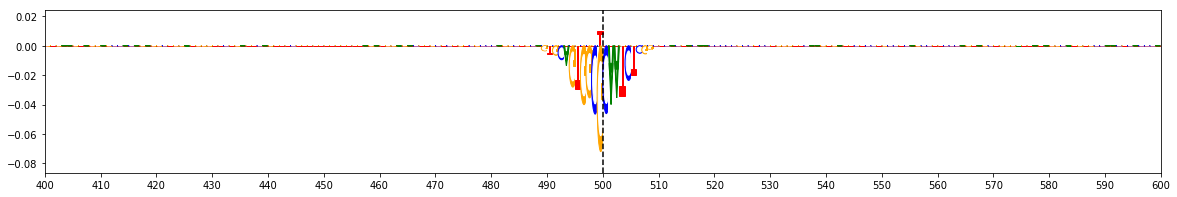


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs2250583   ||    chr15 : 58758182 - 58758183   ||    Locus: 54   ||    IDR Peak: True

GWAS:
Alzheimers_Jansen_2018 		  8.26E-09

Coloc:  False

Noneffect Allele : T   ||   Explain Score : 1.035   ||   Center / 200bp : 0.782
Noneffect Sequence : ATGAGCCATTGAGCCTGGCC


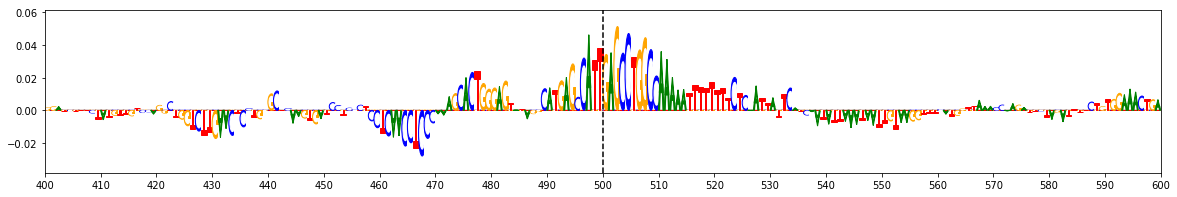

Effect Allele : C   ||   Explain Score : 0.8661   ||   Center / 200bp : 0.75
Effect Sequence : ATGAGCCATCGAGCCTGGCC


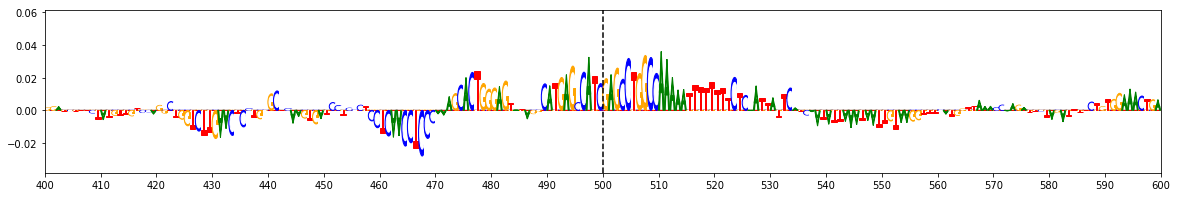

Allele Ratio : 0.8367   ||   Allele Difference : -0.169  ||  ISM Score : -0.2726  ||  deltaSVM Score : -1.5951


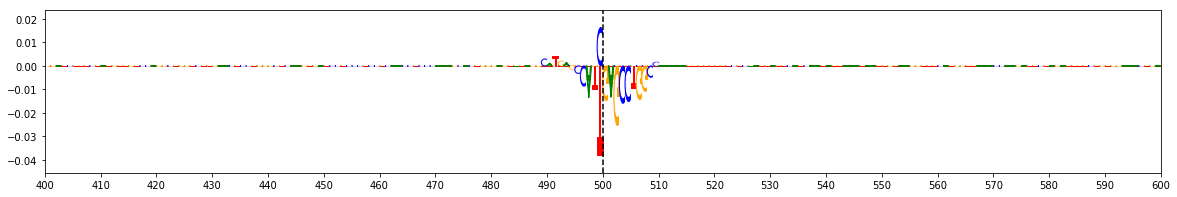


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs2965169   ||    chr19 : 44747898 - 44747899   ||    Locus: 221   ||    IDR Peak: True

GWAS:
Alzheimers_Jansen_2018 		  3.13E-57
Alzheimers_Kunkle_2019 		  2.75E-37
Alzheimers_Lambert_2013 	  5.18E-36

Coloc:  True

Noneffect Allele : A   ||   Explain Score : 0.5854   ||   Center / 200bp : 0.7277
Noneffect Sequence : CCCCCAACGAGTGCAGAGAC


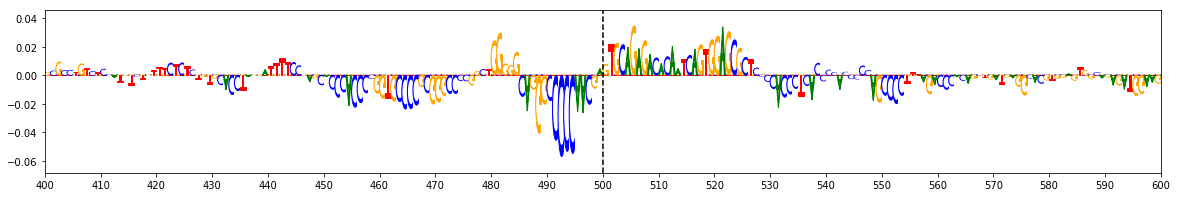

Effect Allele : C   ||   Explain Score : 0.5007   ||   Center / 200bp : 0.6956
Effect Sequence : CCCCCAACGCGTGCAGAGAC


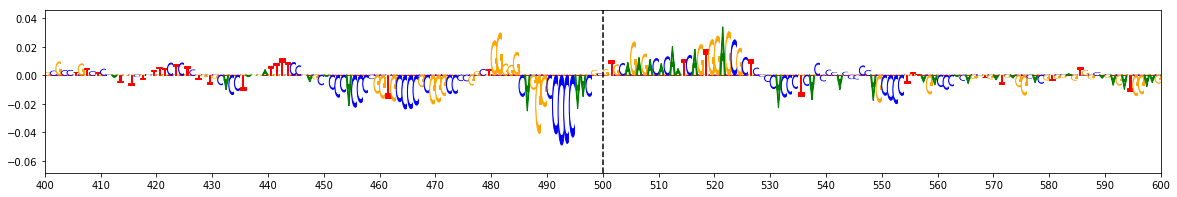

Allele Ratio : 0.8553   ||   Allele Difference : -0.0277  ||  ISM Score : -0.0444  ||  deltaSVM Score : -0.2397


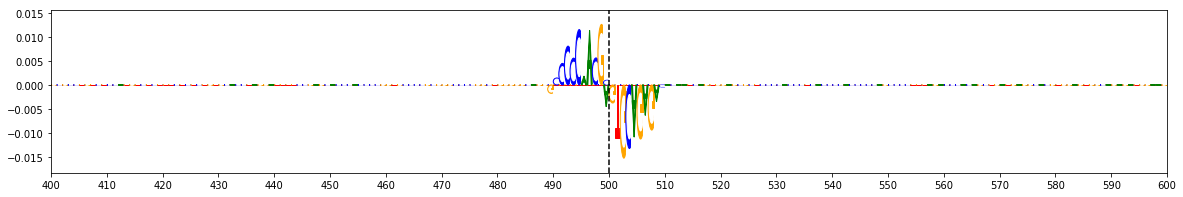


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs6791884   ||    chr3 : 183006617 - 183006618   ||    Locus: 349   ||    IDR Peak: True

GWAS:
23andme_PD_hg38 		  6.00E-09

Coloc:  False

Noneffect Allele : A   ||   Explain Score : 1.6838   ||   Center / 200bp : 0.5694
Noneffect Sequence : AGAGCTGCCAACCAAGGCCA


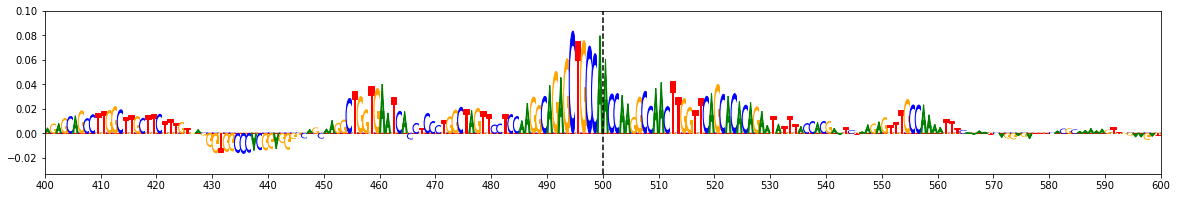

Effect Allele : G   ||   Explain Score : 1.1378   ||   Center / 200bp : 0.4717
Effect Sequence : AGAGCTGCCGACCAAGGCCA


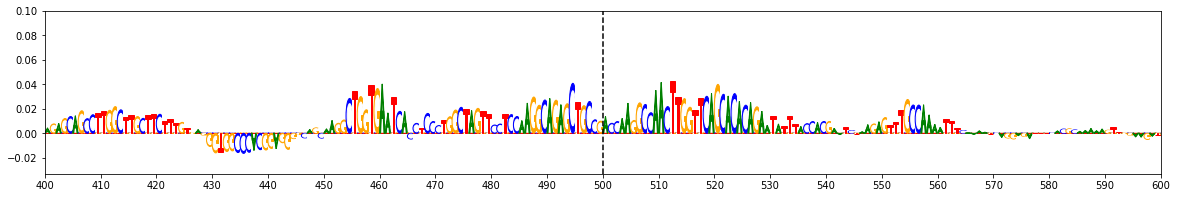

Allele Ratio : 0.6757   ||   Allele Difference : -0.546  ||  ISM Score : -0.8545  ||  deltaSVM Score : -4.9989


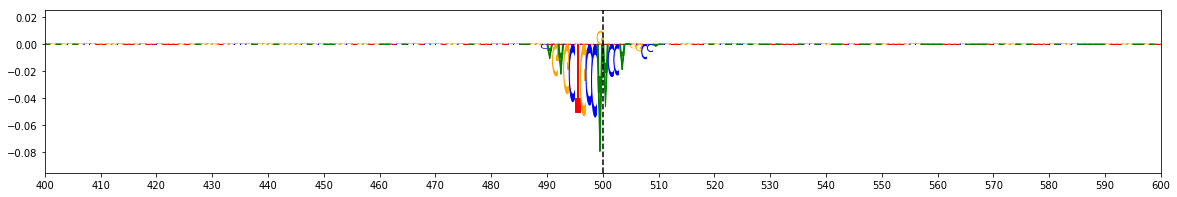


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs3810143   ||    chr19 : 44846144 - 44846145   ||    Locus: 230   ||    IDR Peak: True

GWAS:
Alzheimers_Jansen_2018 		  5.98E-50
Alzheimers_Kunkle_2019 		  1.26E-38
Alzheimers_Lambert_2013 	  4.67E-32

Coloc:  True

Noneffect Allele : T   ||   Explain Score : 1.1805   ||   Center / 200bp : 0.3441
Noneffect Sequence : AGAATTCTTTGGCAGGGGCG


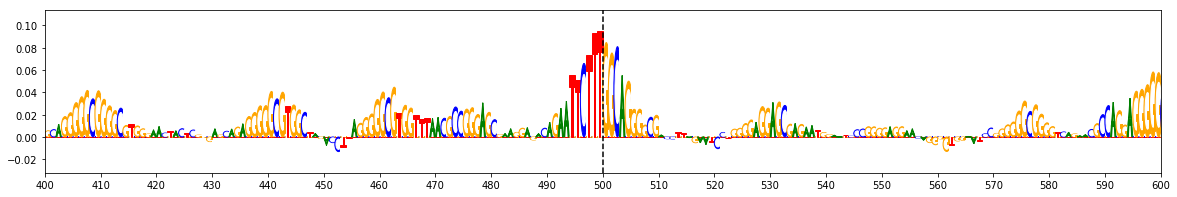

Effect Allele : C   ||   Explain Score : 0.4979   ||   Center / 200bp : 0.1811
Effect Sequence : AGAATTCTTCGGCAGGGGCG


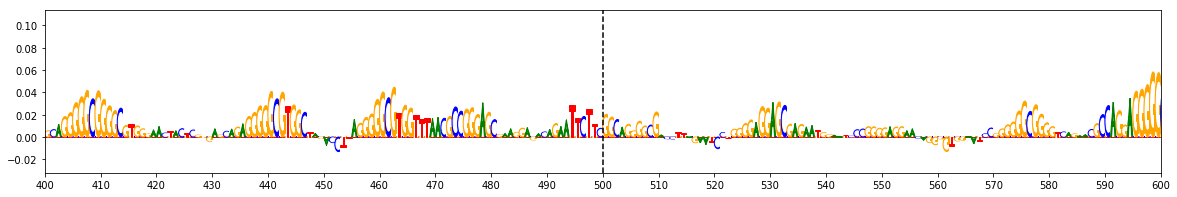

Allele Ratio : 0.4218   ||   Allele Difference : -0.6826  ||  ISM Score : -1.1128  ||  deltaSVM Score : -6.4027


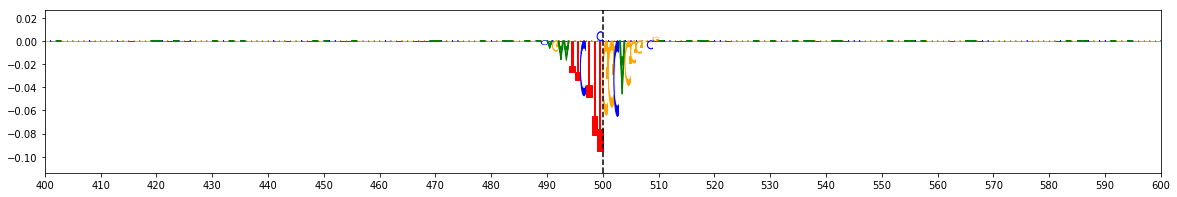


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs150322055   ||    chr3 : 52712648 - 52712649   ||    Locus: 343   ||    IDR Peak: False

GWAS:
Chang_23andMe_Parkinsons 	  2.56E-03

Coloc:  False

Noneffect Allele : C   ||   Explain Score : 0.6506   ||   Center / 200bp : 0.4324
Noneffect Sequence : AGCAGATGCCGGAACCAGAA


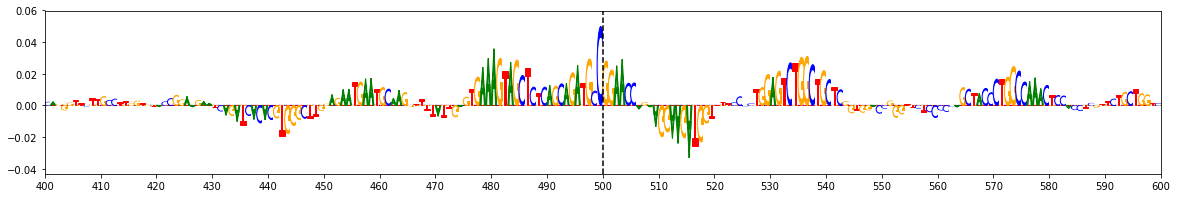

Effect Allele : G   ||   Explain Score : 0.3473   ||   Center / 200bp : 0.2891
Effect Sequence : AGCAGATGCGGGAACCAGAA


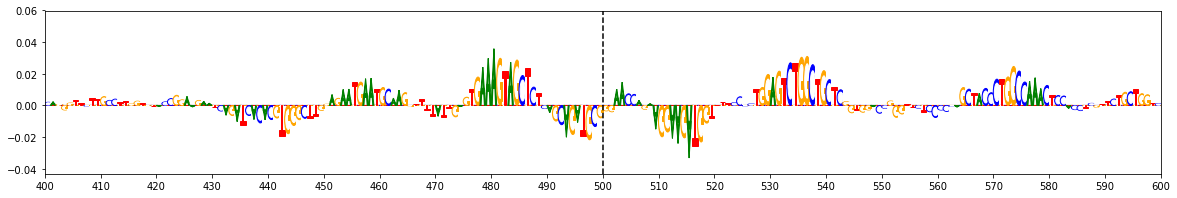

Allele Ratio : 0.5339   ||   Allele Difference : -0.4507  ||  ISM Score : -0.7045  ||  deltaSVM Score : -4.0963


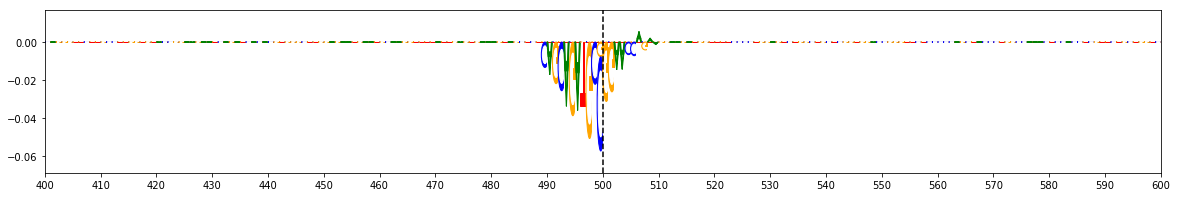


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs896434   ||    chr10 : 15515276 - 15515277   ||    Locus: 11   ||    IDR Peak: False

GWAS:
Chang_23andMe_Parkinsons 	  4.87E-04
Nalls_23andMe 		  4.87E-04

Coloc:  False

Noneffect Allele : G   ||   Explain Score : 1.0818   ||   Center / 200bp : 0.6136
Noneffect Sequence : CAGTGCTCAGCCGTAGTCAG


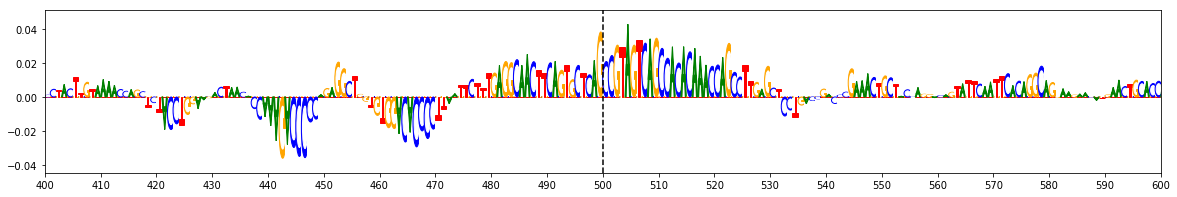

Effect Allele : T   ||   Explain Score : 0.8324   ||   Center / 200bp : 0.5499
Effect Sequence : CAGTGCTCATCCGTAGTCAG


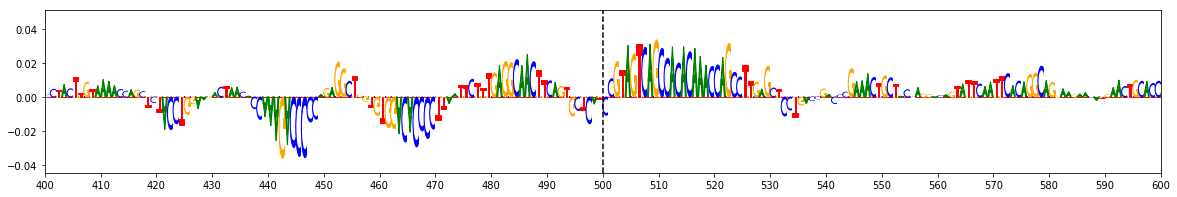

Allele Ratio : 0.7694   ||   Allele Difference : -0.3076  ||  ISM Score : -0.4791  ||  deltaSVM Score : -2.7796


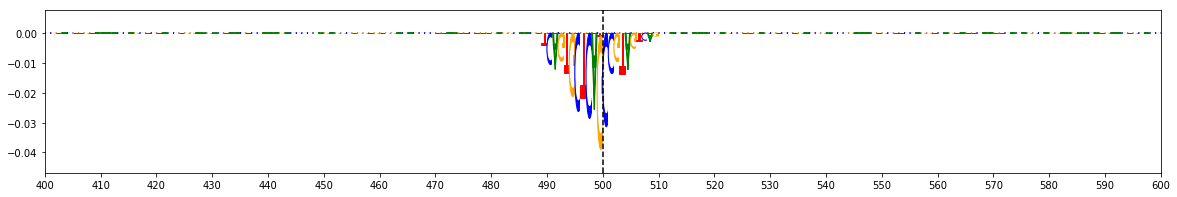


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs62062772   ||    chr17 : 45942947 - 45942948   ||    Locus: 135   ||    IDR Peak: True

GWAS:
23andme_PD_hg38 		  3.65E-22

Coloc:  True

Noneffect Allele : C   ||   Explain Score : 1.3013   ||   Center / 200bp : 0.7676
Noneffect Sequence : GACTCCCTGCACTGCGCTGT


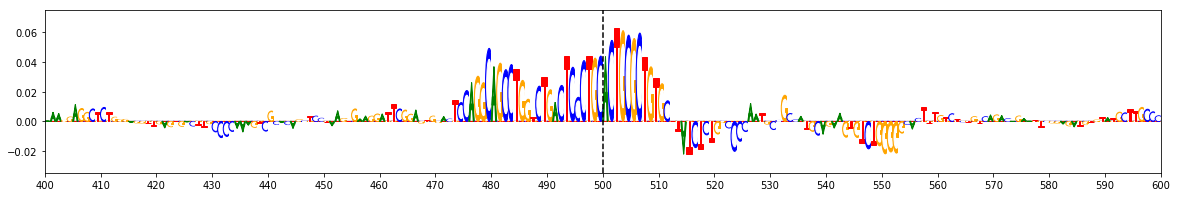

Effect Allele : T   ||   Explain Score : 1.2652   ||   Center / 200bp : 0.7618
Effect Sequence : GACTCCCTGTACTGCGCTGT


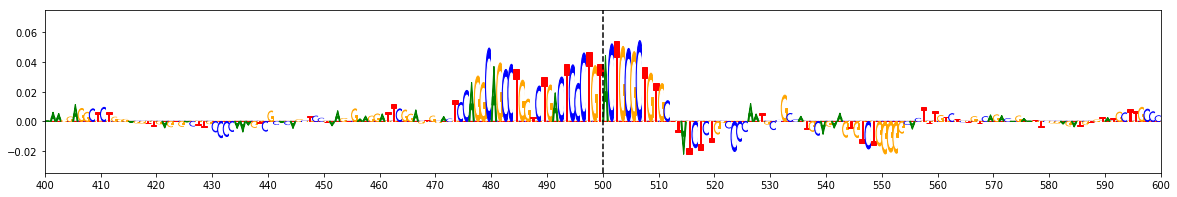

Allele Ratio : 0.9722   ||   Allele Difference : -0.0368  ||  ISM Score : -0.0534  ||  deltaSVM Score : -0.3671


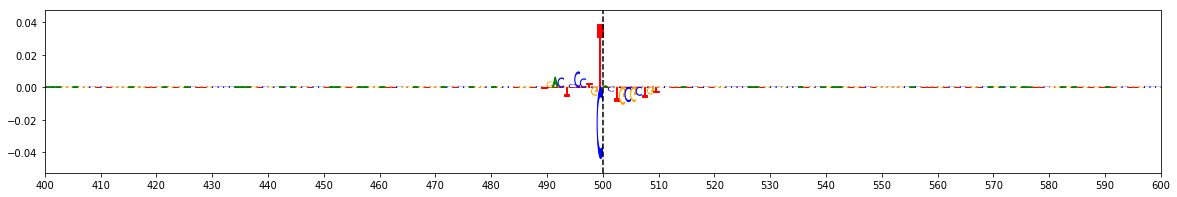


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs10854381   ||    chr21 : 37453051 - 37453052   ||    Locus: 317   ||    IDR Peak: True

GWAS:
Nalls_23andMe 		  3.38E-04

Coloc:  False

Noneffect Allele : A   ||   Explain Score : 0.7848   ||   Center / 200bp : 0.5906
Noneffect Sequence : CAAGGCTGCAGTGAGCTATG


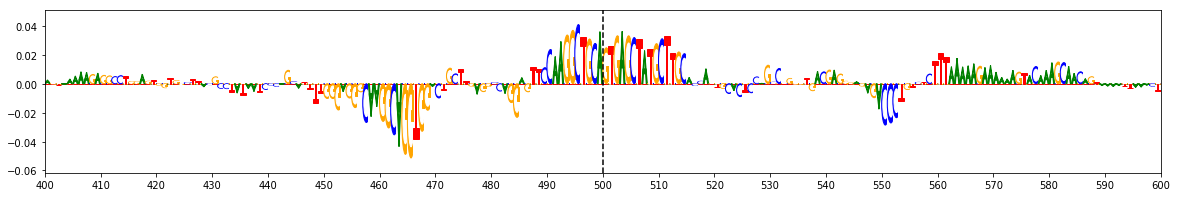

Effect Allele : C   ||   Explain Score : 0.5873   ||   Center / 200bp : 0.5182
Effect Sequence : CAAGGCTGCCGTGAGCTATG


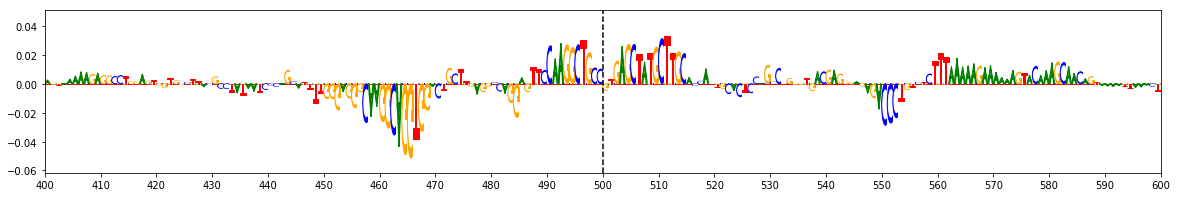

Allele Ratio : 0.7483   ||   Allele Difference : -0.2025  ||  ISM Score : -0.324  ||  deltaSVM Score : -1.8765


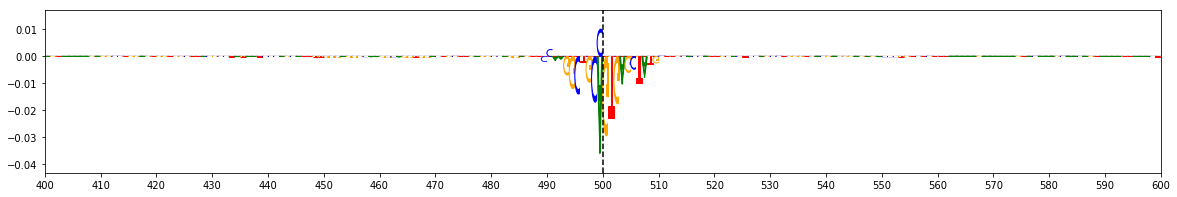


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs7569049   ||    chr2 : 101736882 - 101736883   ||    Locus: 283   ||    IDR Peak: True

GWAS:
Nalls_23andMe 		  1.65E-03
Chang_23andMe_Parkinsons 	  1.65E-03

Coloc:  False

Noneffect Allele : G   ||   Explain Score : 1.0965   ||   Center / 200bp : 0.641
Noneffect Sequence : TAAAGCAGTGAAAGCCCTGG


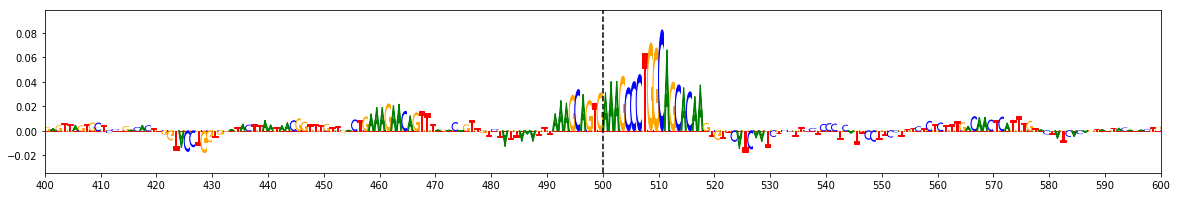

Effect Allele : T   ||   Explain Score : 0.8932   ||   Center / 200bp : 0.5925
Effect Sequence : TAAAGCAGTTAAAGCCCTGG


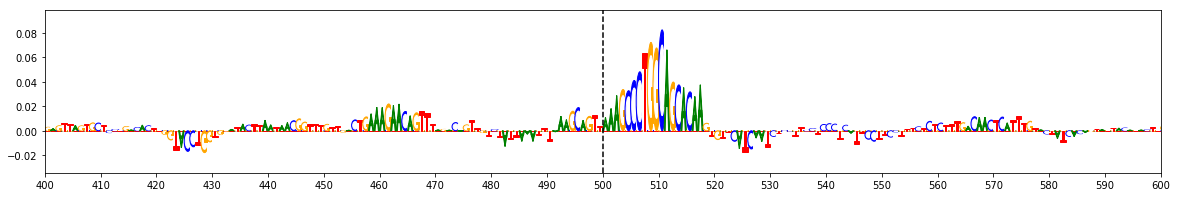

Allele Ratio : 0.8146   ||   Allele Difference : -0.2099  ||  ISM Score : -0.3285  ||  deltaSVM Score : -1.9148


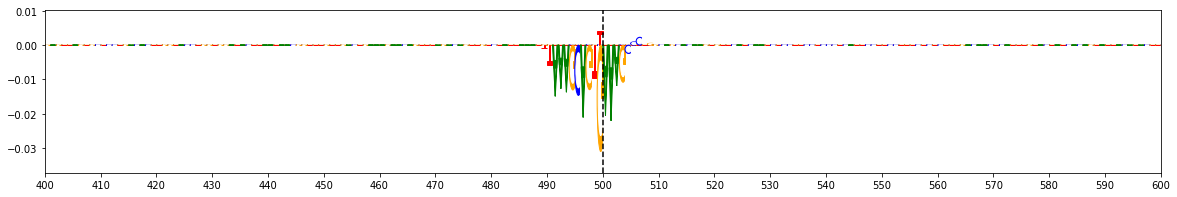


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs72914885   ||    chr17 : 78426790 - 78426791   ||    Locus: 201   ||    IDR Peak: False

GWAS:
Nalls_23andMe 		  4.47E-02

Coloc:  False

Noneffect Allele : A   ||   Explain Score : 1.3532   ||   Center / 200bp : 0.5085
Noneffect Sequence : TGTTCTGGAACTGCCAGAGC


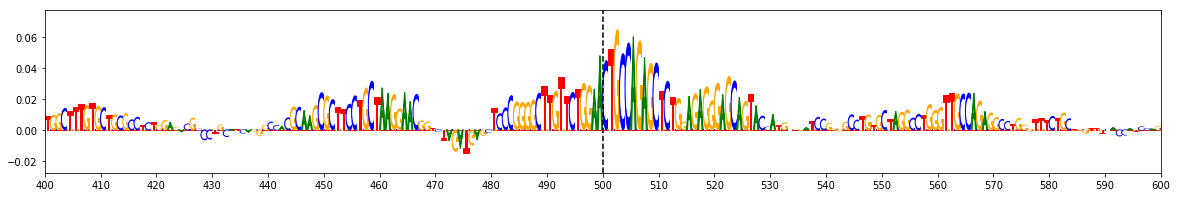

Effect Allele : C   ||   Explain Score : 0.8775   ||   Center / 200bp : 0.4016
Effect Sequence : TGTTCTGGACCTGCCAGAGC


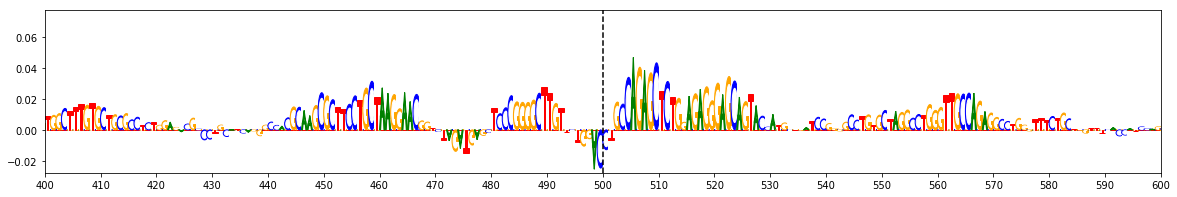

Allele Ratio : 0.6484   ||   Allele Difference : -0.5715  ||  ISM Score : -0.884  ||  deltaSVM Score : -5.2654


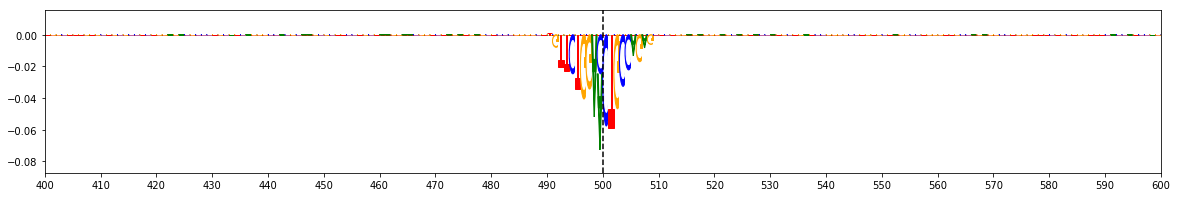


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs11575895   ||    chr17 : 45894418 - 45894419   ||    Locus: 118   ||    IDR Peak: True

GWAS:
23andme_PD_hg38 		  3.94E-22

Coloc:  True

Noneffect Allele : A   ||   Explain Score : 2.6569   ||   Center / 200bp : 0.6751
Noneffect Sequence : GCGCCCACTAGTGGCCGGAG


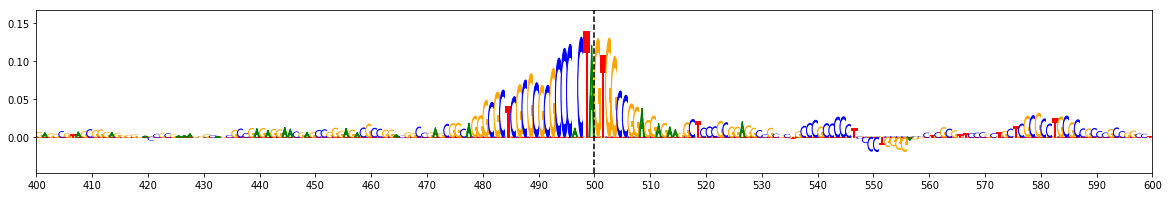

Effect Allele : G   ||   Explain Score : 2.3073   ||   Center / 200bp : 0.6413
Effect Sequence : GCGCCCACTGGTGGCCGGAG


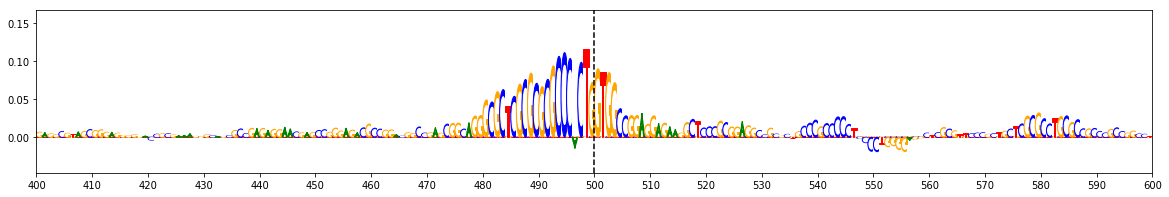

Allele Ratio : 0.8684   ||   Allele Difference : -0.3642  ||  ISM Score : -0.5266  ||  deltaSVM Score : -3.6525


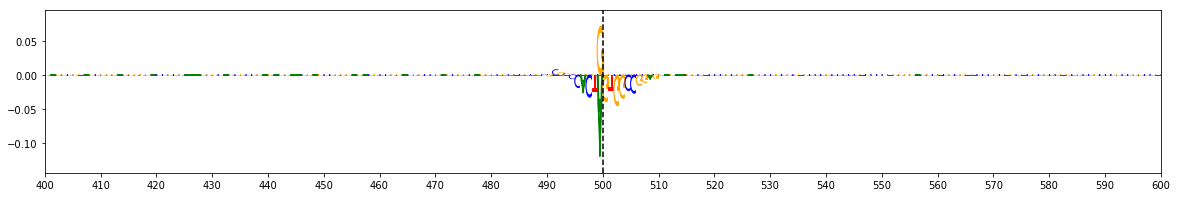


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs6781790   ||    chr3 : 49007333 - 49007334   ||    Locus: 323   ||    IDR Peak: True

GWAS:
Chang_23andMe_Parkinsons 	  2.35E-03
Nalls_23andMe 		  2.35E-03

Coloc:  False

Noneffect Allele : C   ||   Explain Score : 1.1799   ||   Center / 200bp : 0.4207
Noneffect Sequence : AGCTGAGGGCGCTGTTGATG


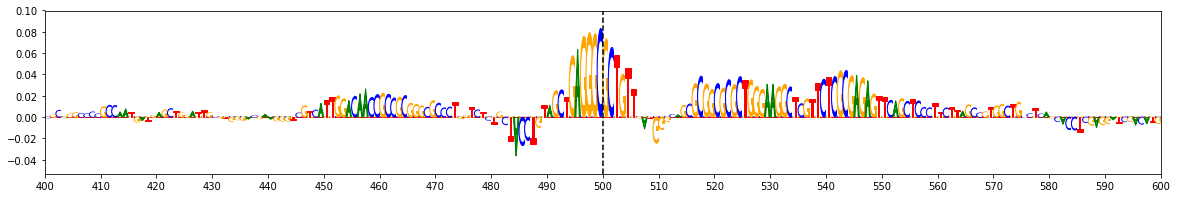

Effect Allele : T   ||   Explain Score : 0.6438   ||   Center / 200bp : 0.2835
Effect Sequence : AGCTGAGGGTGCTGTTGATG


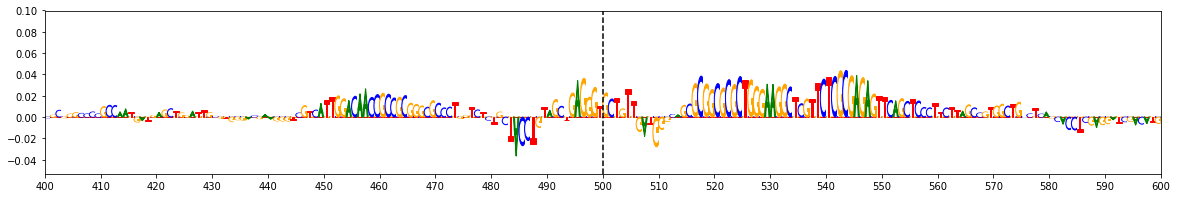

Allele Ratio : 0.5456   ||   Allele Difference : -0.568  ||  ISM Score : -0.8949  ||  deltaSVM Score : -5.1821


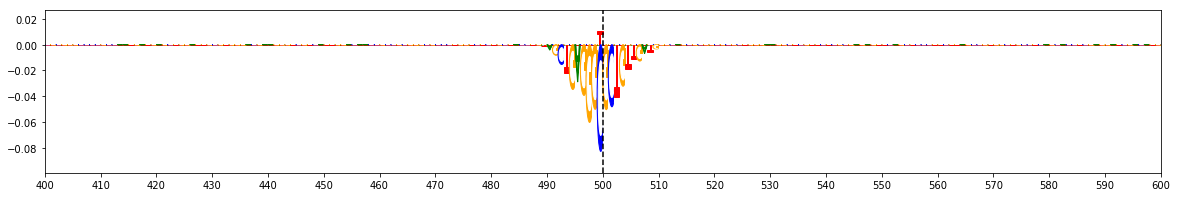


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------




In [6]:
for idx in neg_snps.index[:20]:
    #for idx in [60]:
    print('RSID:', neg_snps.at[idx, 'rsid'],
          '  ||   ', neg_snps.at[idx, 'chr'], ':', neg_snps.at[idx, 'start'], '-', neg_snps.at[idx, 'end'],
          '  ||   ', 'Locus:', idx, '  ||   ', 'IDR Peak:', neg_snps.at[idx, 'idr_peak'])
    
    print()
    
    print('GWAS:')
    
    for i in neg_snps.at[idx, 'all_gwas']:
        entry = i.split(':')
        if 'Lambert' in entry[0] or 'Pankratz' in entry[0] or 'Chang' in entry[0]:
            print(entry[0], '\t', entry[1])
        else:
            print(entry[0], '\t\t', entry[1])
    
    print()
    
    print("Coloc: ", neg_snps.at[idx, 'coloc'])
    
    print()
    
    print('Noneffect Allele :', neg_snps.at[idx, 'noneffect'], '  ||   Explain Score :', round(neg_snps.at[idx, 'noneffect_center'], 4), '  ||   Center / 200bp :', round(neg_snps.at[idx, 'noneffect_ratio'], 4))
    print('Noneffect Sequence :', noneffect_seqs[idx][490:510])
    
    ylim = plot_weights(merged_noneffect_scores[idx], subticks_frequency=10, xlim=(400,600))

    print('Effect Allele :', neg_snps.at[idx, 'effect'], '  ||   Explain Score :', round(neg_snps.at[idx, 'effect_center'], 4), '  ||   Center / 200bp :', round(neg_snps.at[idx, 'effect_ratio'], 4))
    print('Effect Sequence :', effect_seqs[idx][490:510])
    
    a = plot_weights(merged_effect_scores[idx], subticks_frequency=10, ylim=ylim, xlim=(400,600))
    
    print('Allele Ratio :', round(neg_snps.at[idx, 'allele_ratio'], 4), '  ||   Allele Difference :', round(neg_snps.at[idx, 'allele_diff'], 4),
          ' ||  ISM Score :', round(neg_snps.at[idx, 'ism_score'], 4), ' ||  deltaSVM Score :', round(neg_snps.at[idx, 'delta_score'], 4))
    
    a = plot_weights(merged_effect_scores[idx] - merged_noneffect_scores[idx], subticks_frequency=10, xlim=(400,600))
    
    print()
    print('-'*80)
    print('-'*80)
    print()
    print()

## Find Non-Effect Alleles that Improve Accessibility <a name='noneffect_table' />

In [7]:
pos_snps = snps.loc[snps['allele_ratio'] > 1]
pos_snps.sort_values(by=['effect_rank'], ascending=False, inplace=True)
display(pos_snps)

chr      start        end         rsid effect noneffect ref    alt  \
177  chr17   46213482   46213483   rs76475191      T         A   T      A   
32   chr11   86092233   86092234     rs572979      T         C   C      T   
419   chr8   11845330   11845331    rs1736081      T         G   T      G   
426   chr8   22604860   22604861    rs3735901      T         C   T      C   
25   chr11   65834088   65834089   rs17854357      C         G   G    C,T   
57   chr15   64453059   64453060  rs143560707      G         C   C      G   
200  chr17   78426733   78426734   rs72914883      G         A   A      G   
356   chr4     987143     987144   rs10902762      G         A   G      A   
331   chr3   52300205   52300206  rs148628068      G         A   G      A   
70   chr16   31106091   31106092    rs2032915      T         C   C      T   
357   chr4   15735477   15735478   rs11724635      C         A   C      A   
182  chr17   46771150   46771151     rs199523      C         A   C      A   
286   chr2  101762281  101762282    rs2068397      C         A   C      A   
242  chr19   44912841   44912842   rs72654437      A         G   G      A   
279   chr2   95297493   95297494    rs2248415      G         C   C  A,G,T   
310   chr2  134719288  134719289   rs62171396      T         C   C      T   
165  chr17   46059436   46059437   rs62060787      T         G   G      T   
219  chr19   44723890   44723891  rs150820726      T         A   A      T   
162  chr17   46004160   46004161   rs62064665      T         C   T      C   
178  chr17   46213483   46213484   rs78826239      T         A   T      A   
27   chr11   65889092   65889093    rs2231884      T         C   C      T   
41   chr12   41014331   41014332     rs397967      G         A   G      A   
432   chr9   17578708   17578709    rs3758216      G         C   G      C   
396   chr5  103029481  103029482       rs5855      G         A   G      A   
284   chr2  101761911  101761912   rs12476714      G         A   A    C,G   
31   chr11   86069405   86069406    rs3016327      T         C   T      C   
181  chr17   46771071   46771072     rs199524      T         G   G      T   
2     chr1  171699810  171699811   rs10913511      G         A   G      A   
422   chr8   11845910   11845911    rs1736082      T         C   C      T   
42   chr12  122842050  122842051   rs10847864      T         G   G  A,C,T   
..     ...        ...        ...          ...    ...       ...  ..    ...   
431   chr8   27608797   27608798    rs1532278      T         C   T      C   
189  chr17   75034714   75034715   rs11870474      A         C   C    A,T   
207  chr17   78432578   78432579   rs72907463      G         A   G      A   
332   chr3   52320263   52320264  rs147245874      G         A   G      A   
61   chr16   30031355   30031356    rs3814877      T         G   G      T   
353   chr4     973656     973657   rs13137144      G         A   G    A,C   
191  chr17   75035407   75035408   rs80319906      A         G   G      A   
158  chr17   46002200   46002201   rs17573447      T         C   C      T   
267  chr19   45045876   45045877  rs112481437      A         G   G      A   
281   chr2   95330205   95330206    rs3821341      T         C   C      T   
76   chr17    4858616    4858617    rs8067447      T         C   C      T   
183  chr17   49373412   49373413   rs28394864      A         G   G    A,C   
98   chr17   44220262   44220263  rs113844752      C         A   C    A,G   
89   chr17    4902141    4902142   rs72835061      A         C   C      A   
117  chr17   45894237   45894238   rs62056778      G         C   C      G   
382   chr4   89829957   89829958    rs2583980      T         G   T      G   
151  chr17   45974222   45974223  rs118087478      T         G   T      G   
336   chr3   52420197   52420198  rs145672718      G         A   A      G   
247  chr19   44915228   44915229   rs12691088      A         G   G    A,C   
222  chr19   44784591   44784592    rs2927448      T         G   G      T   
160

## Visualize Top Non-Effect Alleles <a name='noneffect_viz' />

RSID: rs76475191   ||    chr17 : 46213482 - 46213483   ||    Locus: 177   ||    IDR Peak: True

GWAS:
23andme_PD_hg38 		  1.10E-18

Coloc:  True

Effect Allele: T   ||  Explain Score: 0.5304   ||  Center / 200bp: 0.7158
Effect Sequence: TTTTTTTTTTTTTTTTAGTA


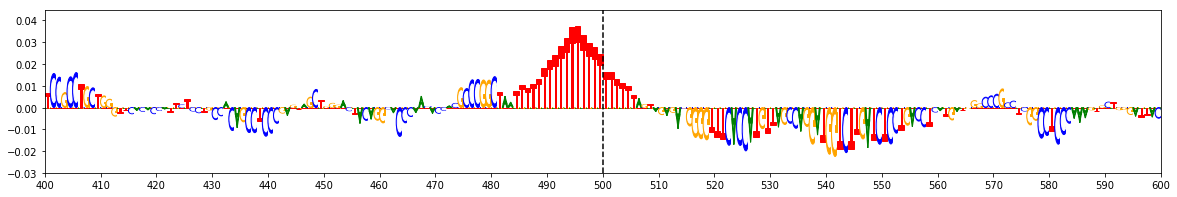

Noneffect Allele: A   ||  Explain Score: 0.3343   ||  Center / 200bp: 0.5445
Noneffect Sequence: TTTTTTTTTATTTTTTAGTA


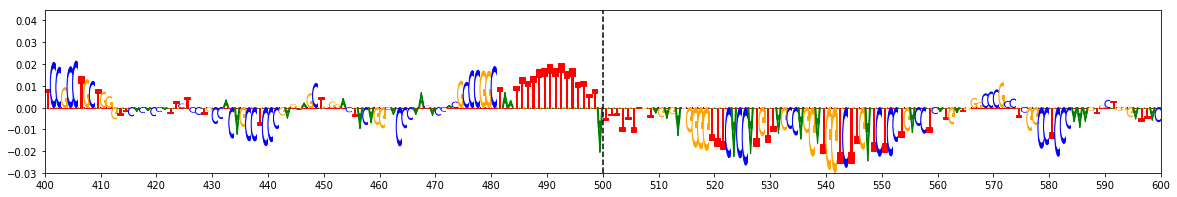

Allele Ratio : 1.5864   ||   Allele Difference : 0.3146  ||  ISM Score : 0.3376  ||  deltaSVM Score : 12.1861


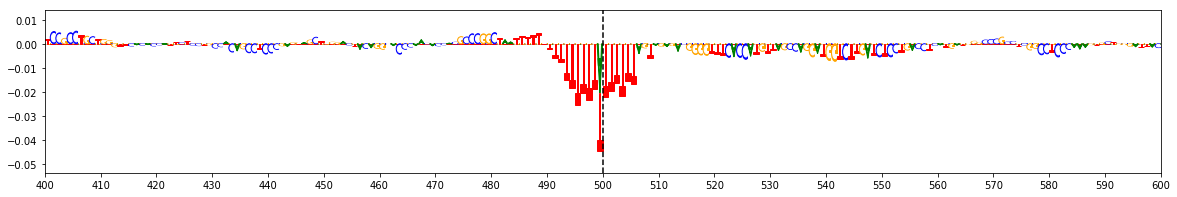


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs572979   ||    chr11 : 86092233 - 86092234   ||    Locus: 32   ||    IDR Peak: True

GWAS:
Alzheimers_Jansen_2018 		  1.19E-08

Coloc:  False

Effect Allele: T   ||  Explain Score: 0.631   ||  Center / 200bp: 0.583
Effect Sequence: GCCTGTAATTGCAGCACTTC


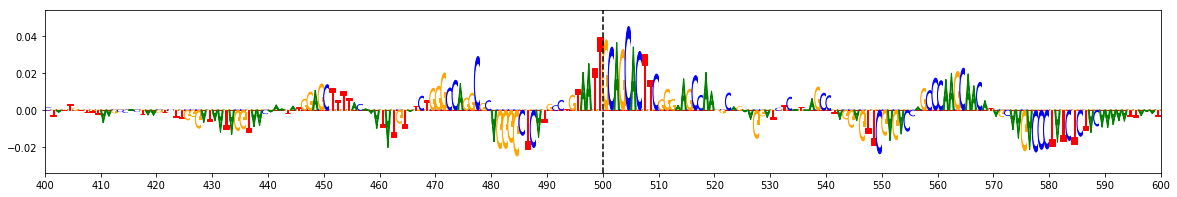

Noneffect Allele: C   ||  Explain Score: 0.3285   ||  Center / 200bp: 0.4214
Noneffect Sequence: GCCTGTAATCGCAGCACTTC


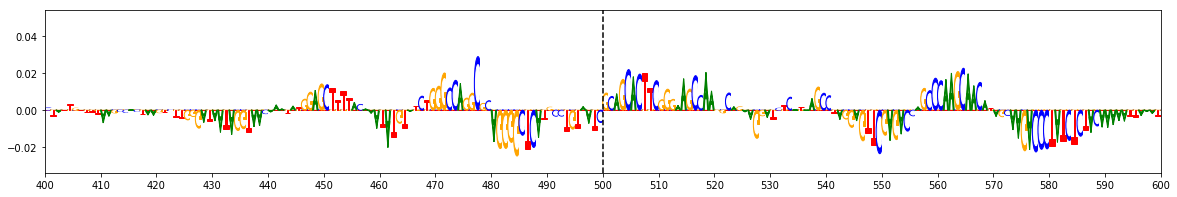

Allele Ratio : 1.9206   ||   Allele Difference : 0.3629  ||  ISM Score : 0.5706  ||  deltaSVM Score : 3.2829


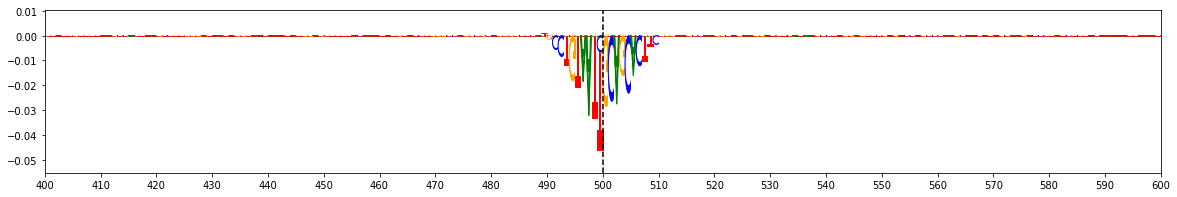


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs1736081   ||    chr8 : 11845330 - 11845331   ||    Locus: 419   ||    IDR Peak: True

GWAS:
Chang_23andMe_Parkinsons 	  1.11E-04

Coloc:  False

Effect Allele: T   ||  Explain Score: 0.5623   ||  Center / 200bp: 0.5629
Effect Sequence: TCCTGCTGTTGGCCCACTAG


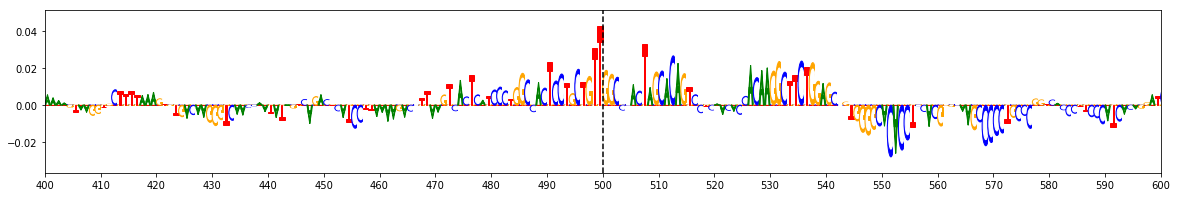

Noneffect Allele: G   ||  Explain Score: 0.2947   ||  Center / 200bp: 0.4042
Noneffect Sequence: TCCTGCTGTGGGCCCACTAG


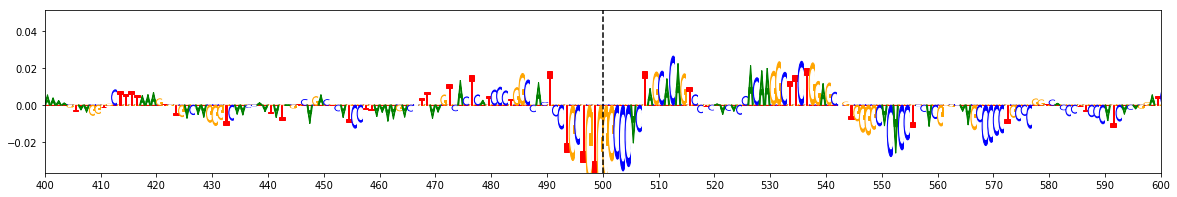

Allele Ratio : 1.908   ||   Allele Difference : 0.7281  ||  ISM Score : 1.1336  ||  deltaSVM Score : 6.5631


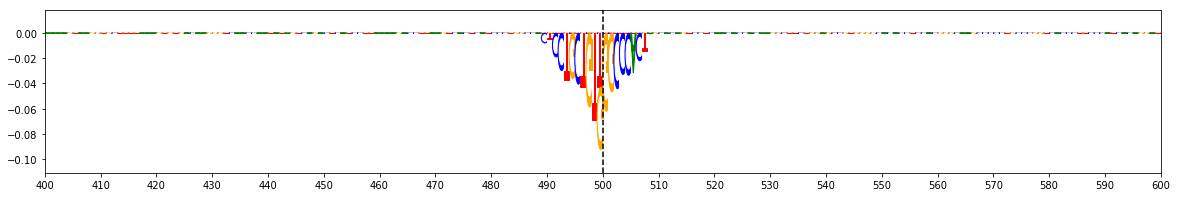


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs3735901   ||    chr8 : 22604860 - 22604861   ||    Locus: 426   ||    IDR Peak: True

GWAS:
Chang_23andMe_Parkinsons 	  5.08E-02
Nalls_23andMe 		  5.08E-02

Coloc:  False

Effect Allele: T   ||  Explain Score: 0.2237   ||  Center / 200bp: 0.1496
Effect Sequence: GGGGCCCCCTGCCGCCCCTC


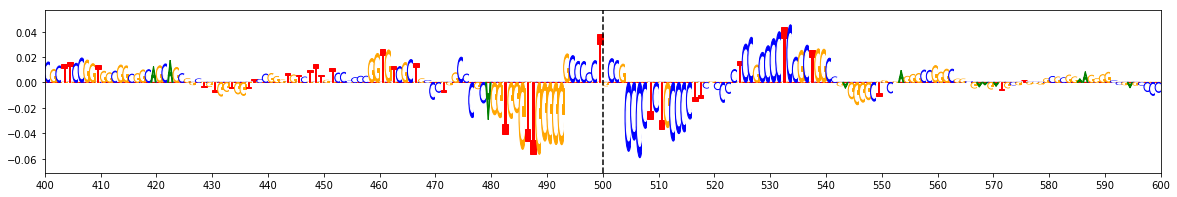

Noneffect Allele: C   ||  Explain Score: 0.033   ||  Center / 200bp: 0.0261
Noneffect Sequence: GGGGCCCCCCGCCGCCCCTC


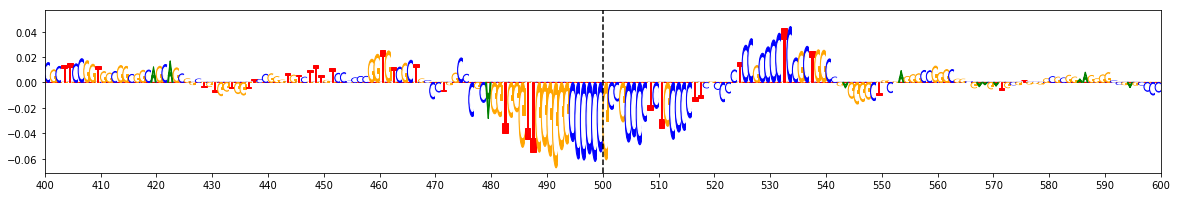

Allele Ratio : 6.7761   ||   Allele Difference : 0.6854  ||  ISM Score : 1.0703  ||  deltaSVM Score : 7.1612


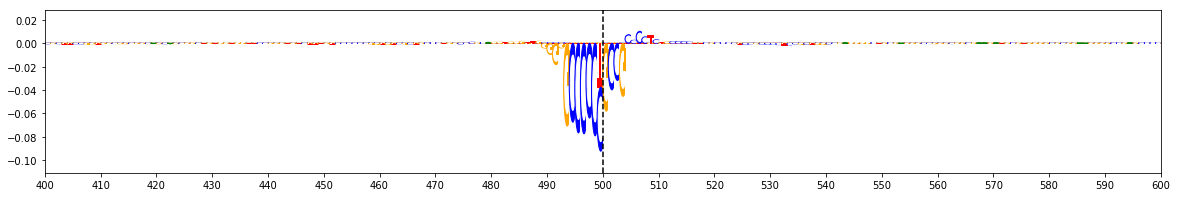


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs17854357   ||    chr11 : 65834088 - 65834089   ||    Locus: 25   ||    IDR Peak: True

GWAS:
Alzheimers_Jansen_2018 		  3.26E-06

Coloc:  True

Effect Allele: C   ||  Explain Score: 0.5761   ||  Center / 200bp: 0.494
Effect Sequence: GGAGGTTGGCAAGGAGGGCA


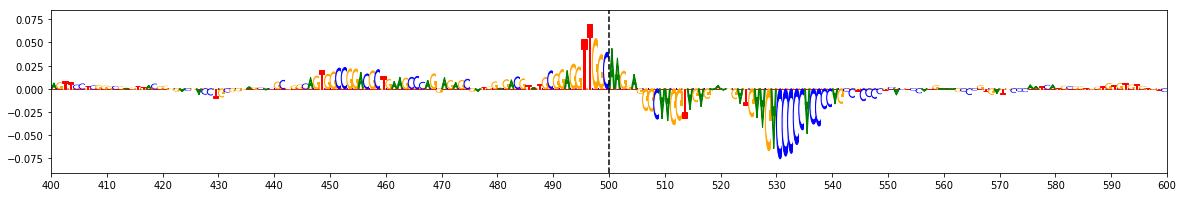

Noneffect Allele: G   ||  Explain Score: 0.2966   ||  Center / 200bp: 0.3345
Noneffect Sequence: GGAGGTTGGGAAGGAGGGCA


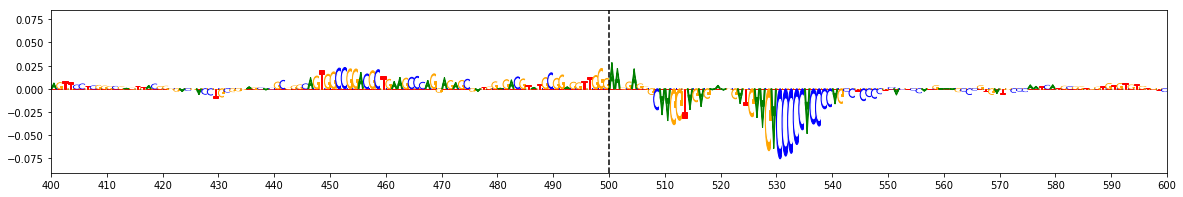

Allele Ratio : 1.9425   ||   Allele Difference : 0.2189  ||  ISM Score : 0.3689  ||  deltaSVM Score : 2.1122


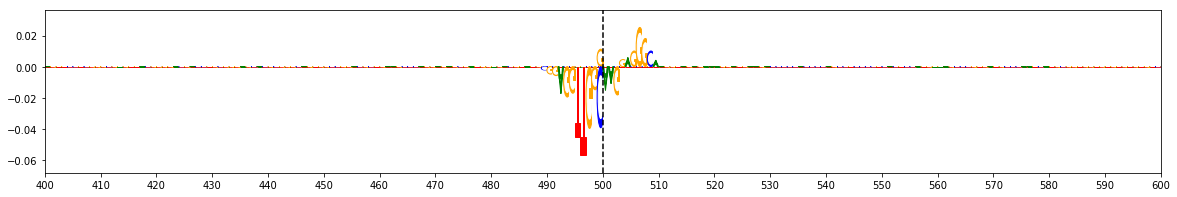


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs143560707   ||    chr15 : 64453059 - 64453060   ||    Locus: 57   ||    IDR Peak: True

GWAS:
Alzheimers_Lambert_2013 	  3.03E-06

Coloc:  True

Effect Allele: G   ||  Explain Score: 0.4067   ||  Center / 200bp: 0.4721
Effect Sequence: TGGCACACAGCTGTAGTCCC


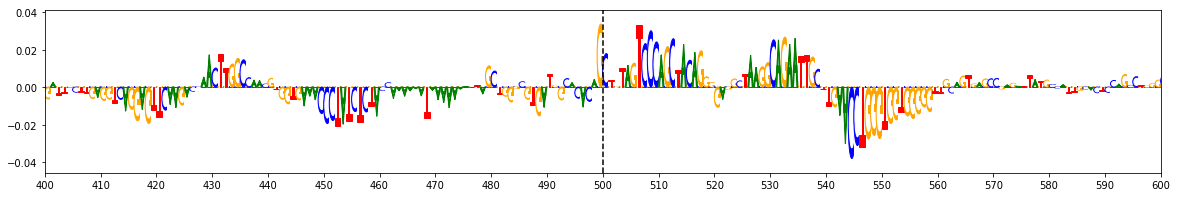

Noneffect Allele: C   ||  Explain Score: 0.2023   ||  Center / 200bp: 0.3082
Noneffect Sequence: TGGCACACACCTGTAGTCCC


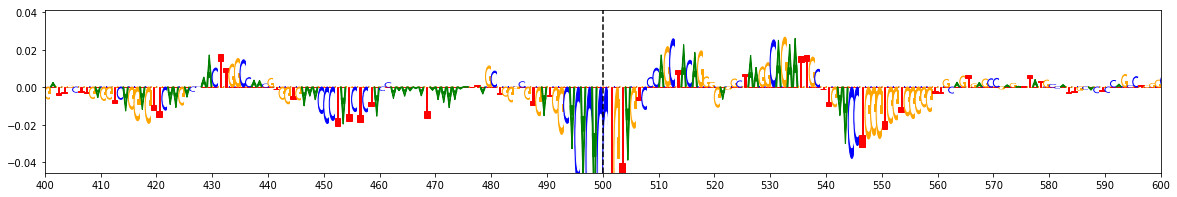

Allele Ratio : 2.01   ||   Allele Difference : 1.0233  ||  ISM Score : 1.6059  ||  deltaSVM Score : 9.2876


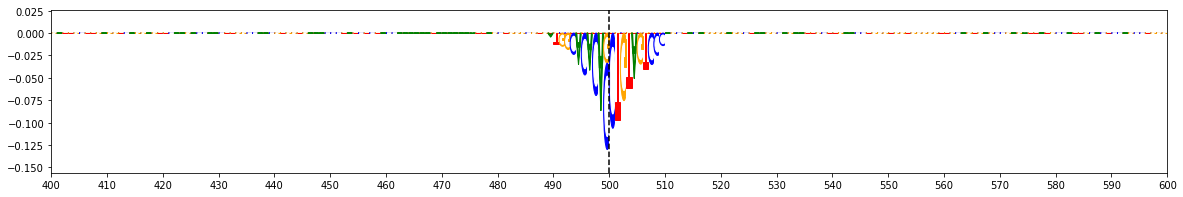


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs72914883   ||    chr17 : 78426733 - 78426734   ||    Locus: 200   ||    IDR Peak: False

GWAS:
Nalls_23andMe 		  4.46E-02

Coloc:  False

Effect Allele: G   ||  Explain Score: 1.5804   ||  Center / 200bp: 0.4994
Effect Sequence: ATCAGGGCCGCGCAAGCGCT


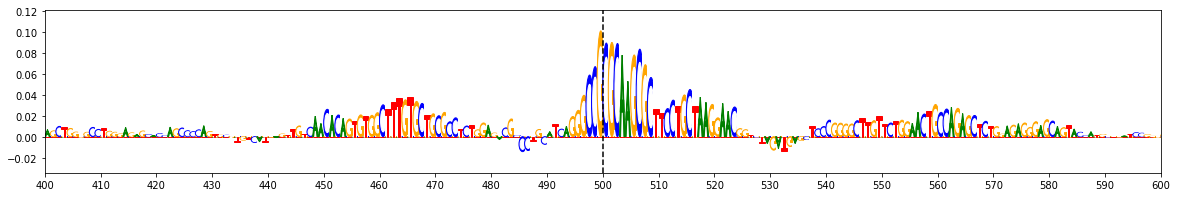

Noneffect Allele: A   ||  Explain Score: 0.8477   ||  Center / 200bp: 0.3486
Noneffect Sequence: ATCAGGGCCACGCAAGCGCT


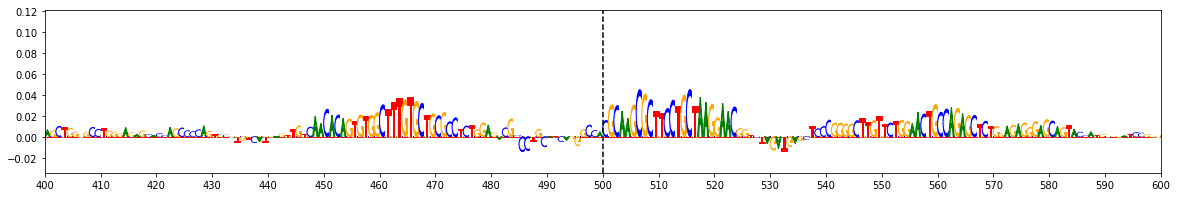

Allele Ratio : 1.8644   ||   Allele Difference : 0.7533  ||  ISM Score : 1.183  ||  deltaSVM Score : 6.8291


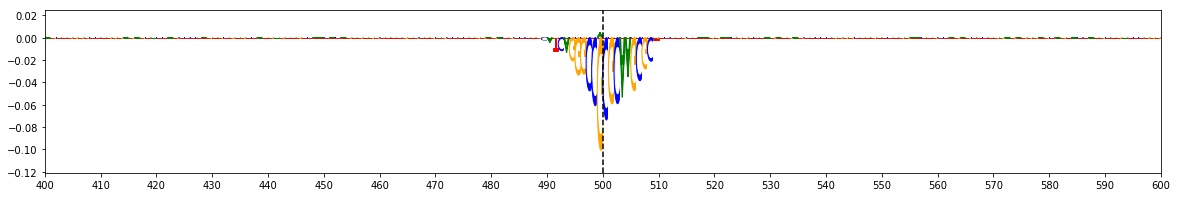


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs10902762   ||    chr4 : 987143 - 987144   ||    Locus: 356   ||    IDR Peak: True

GWAS:
23andme_PD_hg38 		  3.90E-11

Coloc:  True

Effect Allele: G   ||  Explain Score: 0.5516   ||  Center / 200bp: 0.5341
Effect Sequence: CCTGGCCGCGCCCCCGGTGG


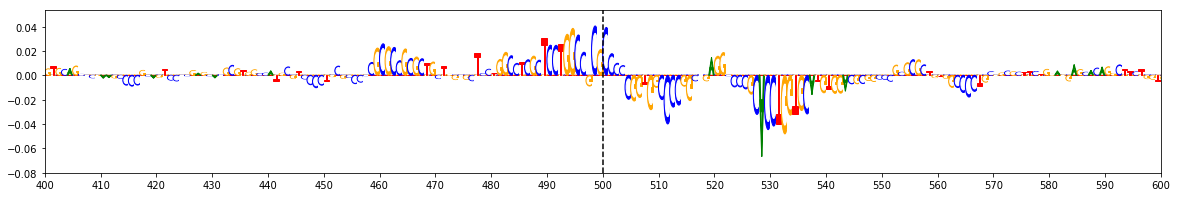

Noneffect Allele: A   ||  Explain Score: 0.3295   ||  Center / 200bp: 0.4027
Noneffect Sequence: CCTGGCCGCACCCCCGGTGG


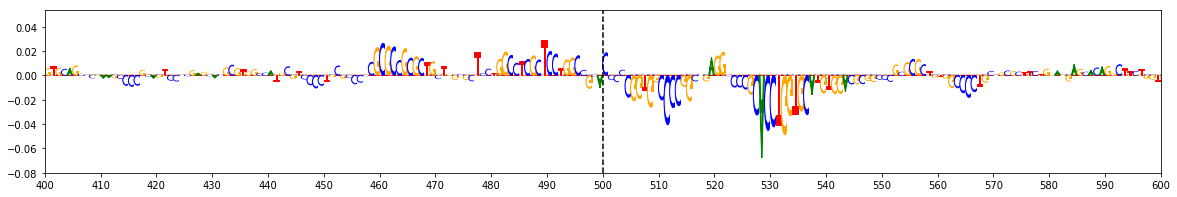

Allele Ratio : 1.6741   ||   Allele Difference : 0.2449  ||  ISM Score : 0.3971  ||  deltaSVM Score : 2.4453


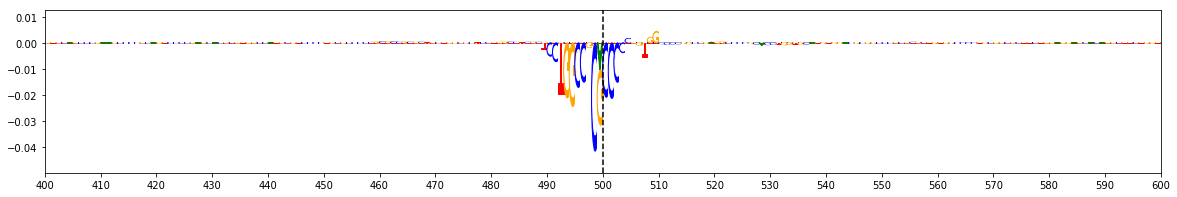


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs148628068   ||    chr3 : 52300205 - 52300206   ||    Locus: 331   ||    IDR Peak: False

GWAS:
Chang_23andMe_Parkinsons 	  9.94E-04

Coloc:  False

Effect Allele: G   ||  Explain Score: 0.1367   ||  Center / 200bp: 0.1139
Effect Sequence: AGCAGGGCCGTCCCAACCCT


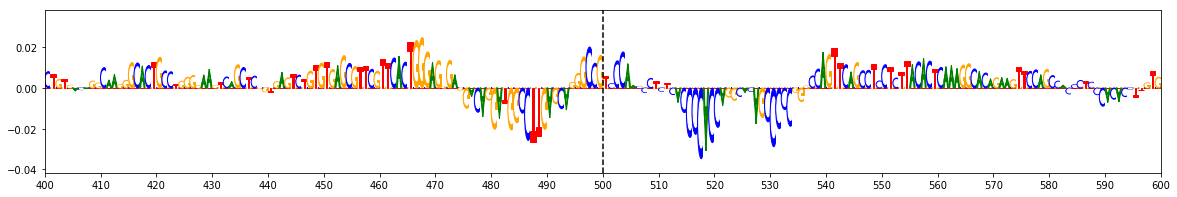

Noneffect Allele: A   ||  Explain Score: 0.0183   ||  Center / 200bp: 0.0169
Noneffect Sequence: AGCAGGGCCATCCCAACCCT


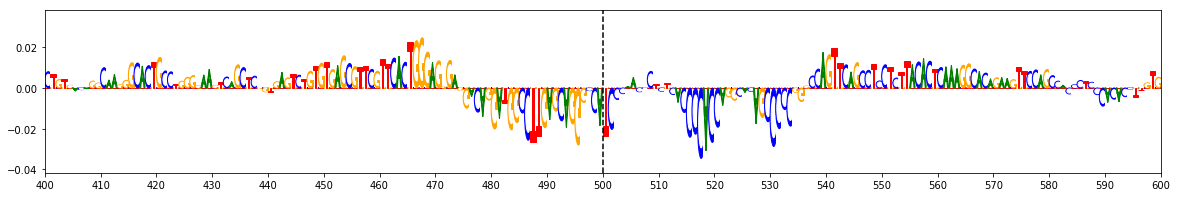

Allele Ratio : 7.4789   ||   Allele Difference : 0.2724  ||  ISM Score : 0.4242  ||  deltaSVM Score : 2.4578


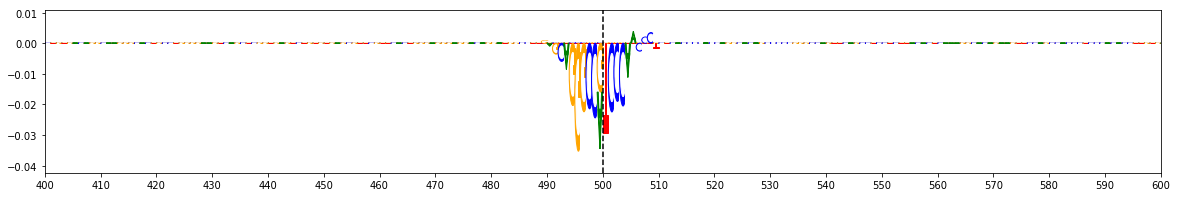


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs2032915   ||    chr16 : 31106091 - 31106092   ||    Locus: 70   ||    IDR Peak: True

GWAS:
Chang_23andMe_Parkinsons 	  3.22E-02

Coloc:  False

Effect Allele: T   ||  Explain Score: 1.2095   ||  Center / 200bp: 0.6383
Effect Sequence: CTGGCTGTATTCCAGGACGT


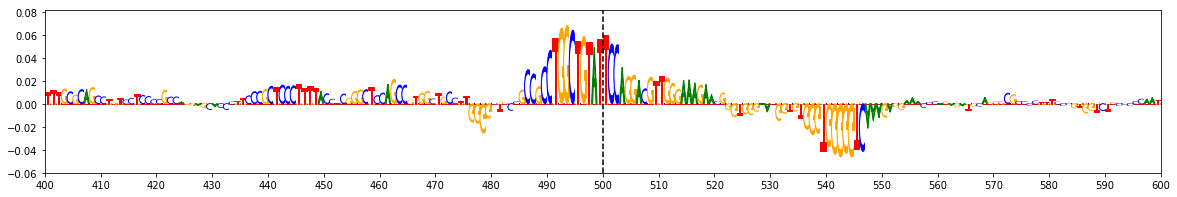

Noneffect Allele: C   ||  Explain Score: 0.9104   ||  Center / 200bp: 0.5707
Noneffect Sequence: CTGGCTGTACTCCAGGACGT


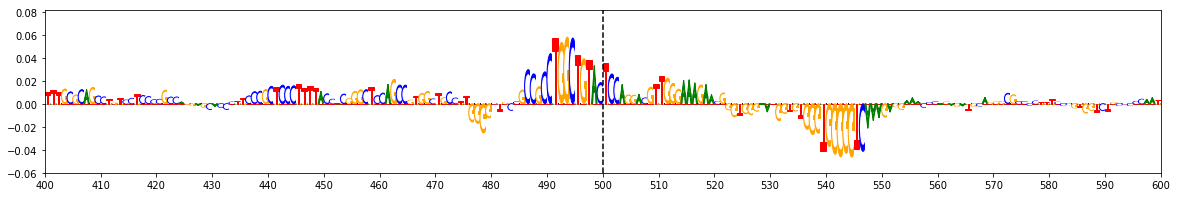

Allele Ratio : 1.3285   ||   Allele Difference : 0.299  ||  ISM Score : 0.4705  ||  deltaSVM Score : 2.7222


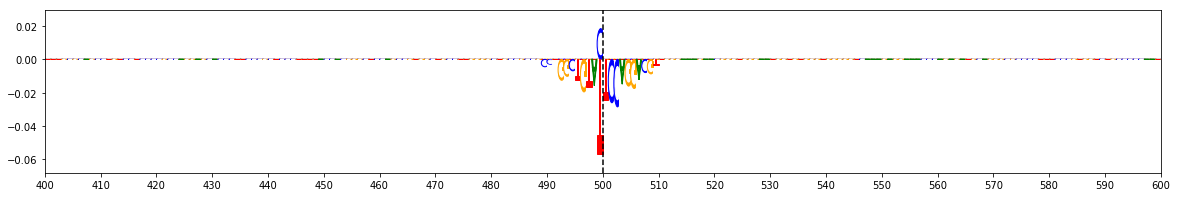


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs11724635   ||    chr4 : 15735477 - 15735478   ||    Locus: 357   ||    IDR Peak: True

GWAS:
Nalls_23andMe 		  1.04E-04
Chang_23andMe_Parkinsons 	  1.04E-04

Coloc:  False

Effect Allele: C   ||  Explain Score: 0.4396   ||  Center / 200bp: 0.382
Effect Sequence: CAAGGGAAGCTTAATAACAA


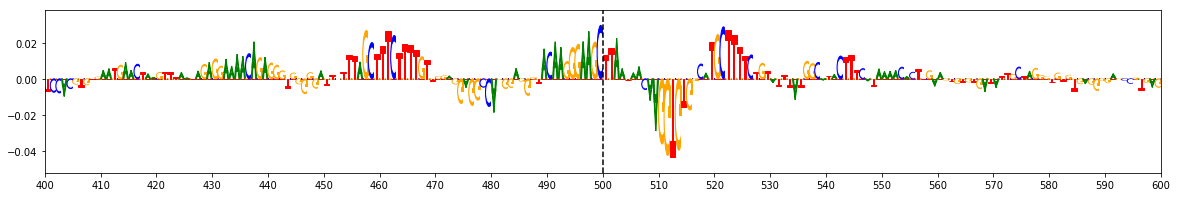

Noneffect Allele: A   ||  Explain Score: 0.2038   ||  Center / 200bp: 0.2229
Noneffect Sequence: CAAGGGAAGATTAATAACAA


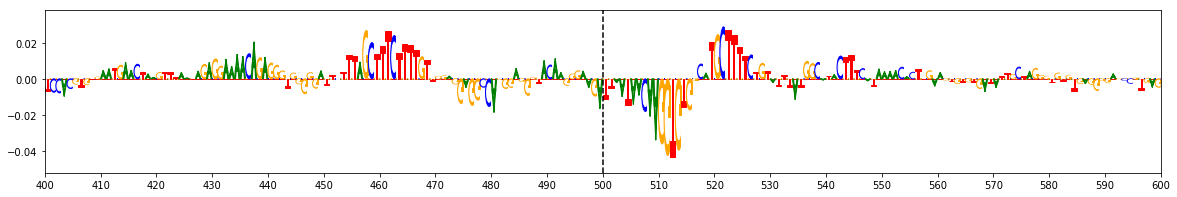

Allele Ratio : 2.1566   ||   Allele Difference : 0.3613  ||  ISM Score : 0.5666  ||  deltaSVM Score : 3.2958


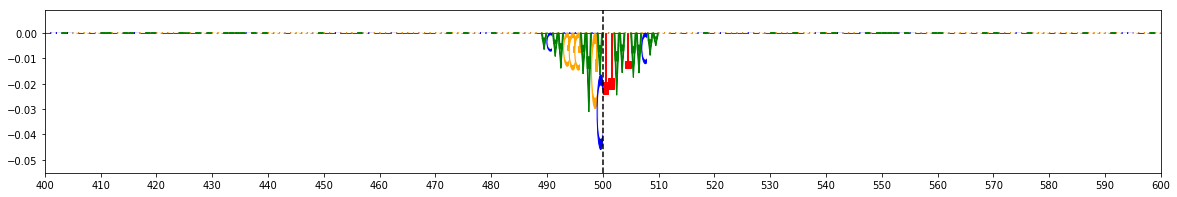


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs199523   ||    chr17 : 46771150 - 46771151   ||    Locus: 182   ||    IDR Peak: True

GWAS:
23andme_PD_hg38 		  9.49E-14

Coloc:  True

Effect Allele: C   ||  Explain Score: 1.1615   ||  Center / 200bp: 0.3789
Effect Sequence: GCCCTCCTGCGCCACCTACA


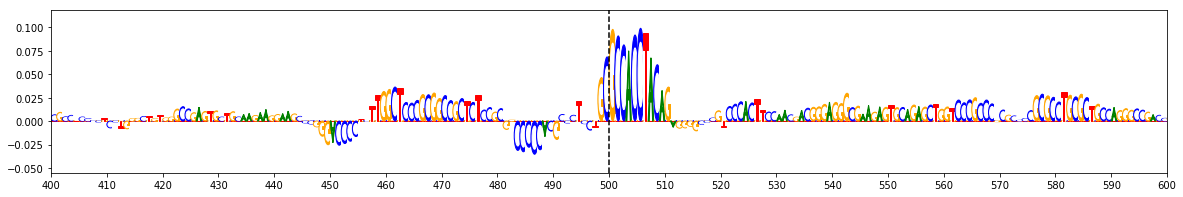

Noneffect Allele: A   ||  Explain Score: 0.5373   ||  Center / 200bp: 0.2198
Noneffect Sequence: GCCCTCCTGAGCCACCTACA


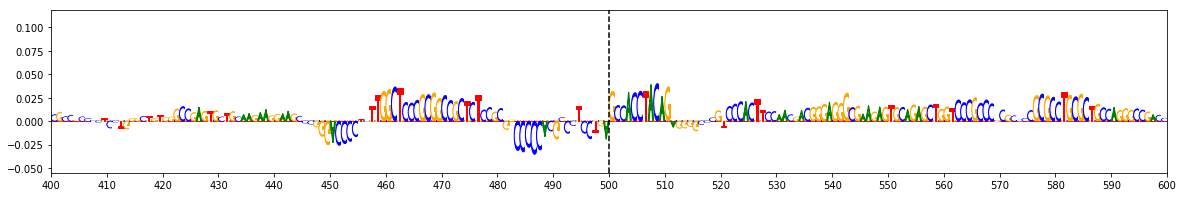

Allele Ratio : 2.1616   ||   Allele Difference : 0.6883  ||  ISM Score : 1.0929  ||  deltaSVM Score : 6.3148


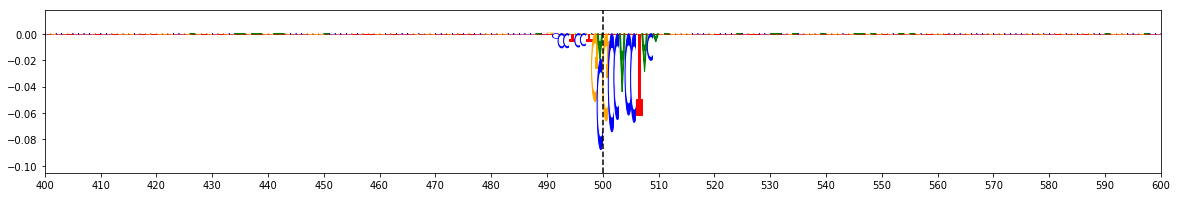


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs2068397   ||    chr2 : 101762281 - 101762282   ||    Locus: 286   ||    IDR Peak: True

GWAS:
Chang_23andMe_Parkinsons 	  1.14E-03
Nalls_23andMe 		  1.14E-03

Coloc:  False

Effect Allele: C   ||  Explain Score: 0.5436   ||  Center / 200bp: 0.383
Effect Sequence: GGCAAATTGCCACACCTAGG


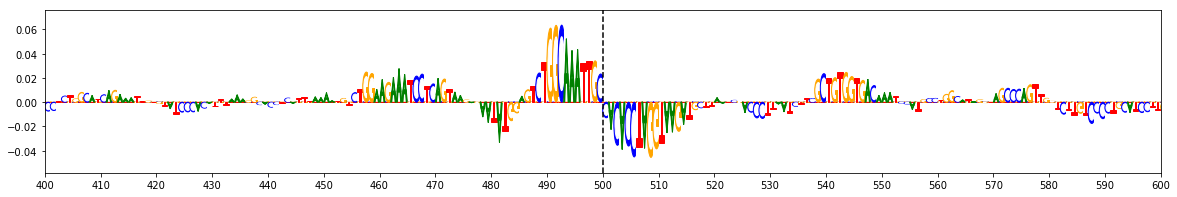

Noneffect Allele: A   ||  Explain Score: 0.2555   ||  Center / 200bp: 0.2247
Noneffect Sequence: GGCAAATTGACACACCTAGG


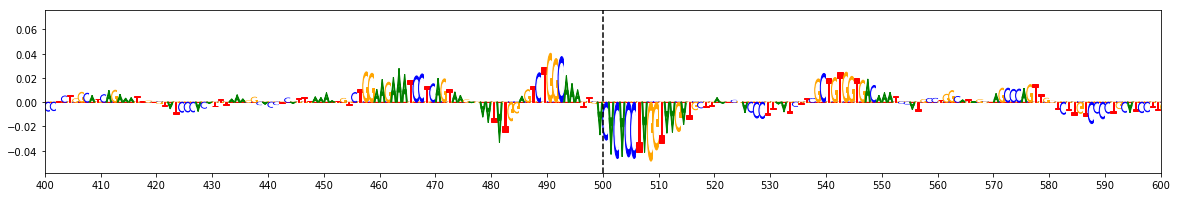

Allele Ratio : 2.1274   ||   Allele Difference : 0.3988  ||  ISM Score : 0.6226  ||  deltaSVM Score : 3.4863


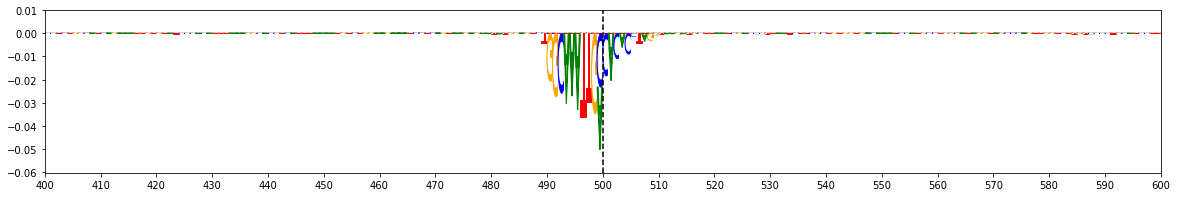


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs72654437   ||    chr19 : 44912841 - 44912842   ||    Locus: 242   ||    IDR Peak: True

GWAS:
Alzheimers_Kunkle_2019 		  2.28E-09

Coloc:  True

Effect Allele: A   ||  Explain Score: 0.6826   ||  Center / 200bp: 0.5266
Effect Sequence: ATTCTTGTGAGGTCTGGGAA


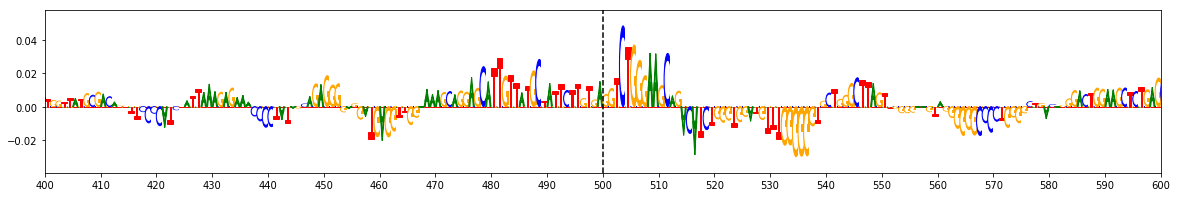

Noneffect Allele: G   ||  Explain Score: 0.4418   ||  Center / 200bp: 0.4186
Noneffect Sequence: ATTCTTGTGGGGTCTGGGAA


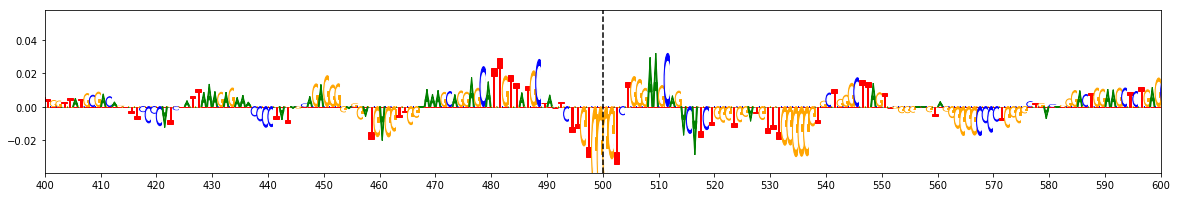

Allele Ratio : 1.545   ||   Allele Difference : 0.559  ||  ISM Score : 0.8735  ||  deltaSVM Score : 5.0129


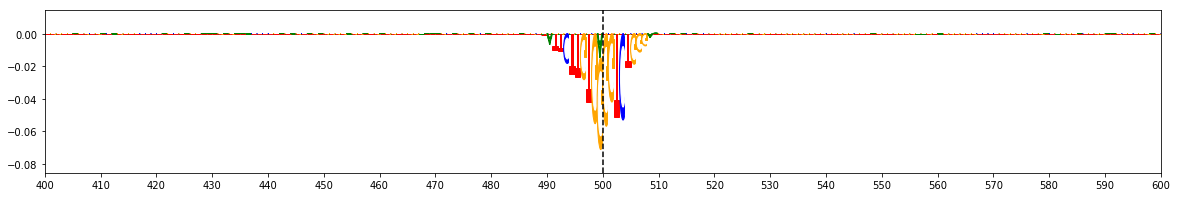


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs2248415   ||    chr2 : 95297493 - 95297494   ||    Locus: 279   ||    IDR Peak: True

GWAS:
Nalls_23andMe 		  7.83E-03

Coloc:  False

Effect Allele: G   ||  Explain Score: 0.3417   ||  Center / 200bp: 0.2683
Effect Sequence: GAGGGGGGTGGGGGGGAGGA


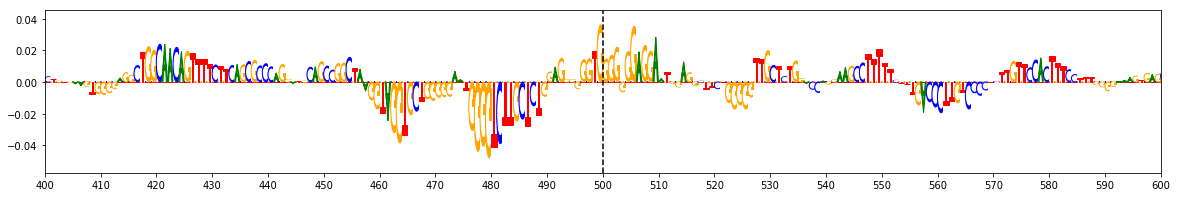

Noneffect Allele: C   ||  Explain Score: 0.1151   ||  Center / 200bp: 0.109
Noneffect Sequence: GAGGGGGGTCGGGGGGAGGA


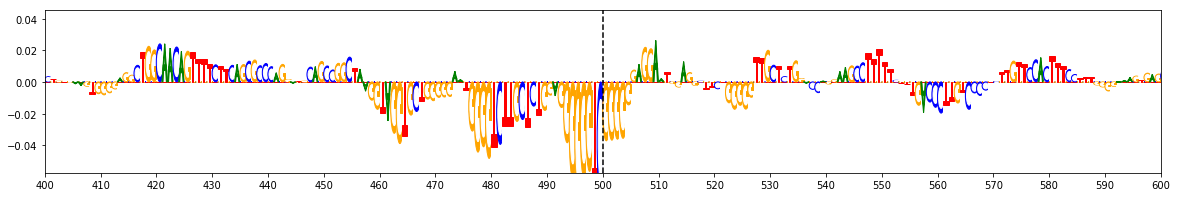

Allele Ratio : 2.9674   ||   Allele Difference : 0.854  ||  ISM Score : 1.3665  ||  deltaSVM Score : 7.9079


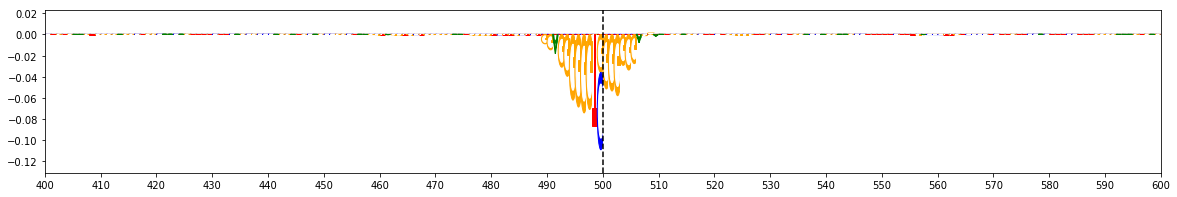


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs62171396   ||    chr2 : 134719288 - 134719289   ||    Locus: 310   ||    IDR Peak: False

GWAS:
Nalls_23andMe 		  1.04E-02

Coloc:  False

Effect Allele: T   ||  Explain Score: 1.3339   ||  Center / 200bp: 0.6736
Effect Sequence: ACAGGCGGCTCTGGCAGAGC


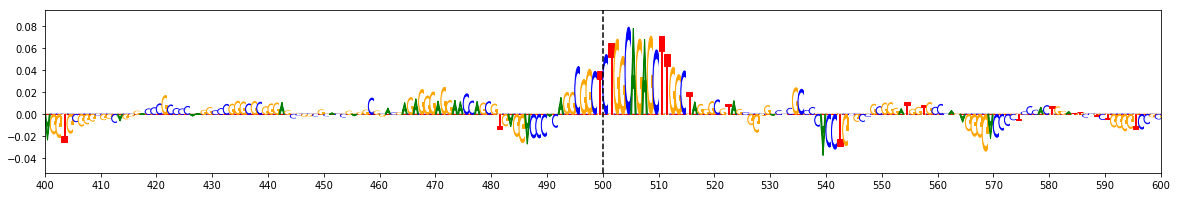

Noneffect Allele: C   ||  Explain Score: 1.1392   ||  Center / 200bp: 0.6368
Noneffect Sequence: ACAGGCGGCCCTGGCAGAGC


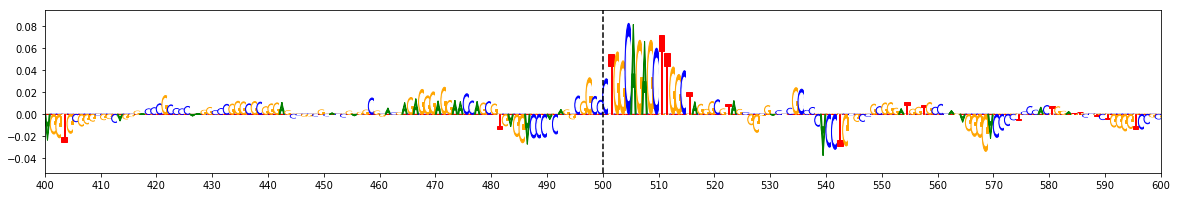

Allele Ratio : 1.1709   ||   Allele Difference : 0.2093  ||  ISM Score : 0.3243  ||  deltaSVM Score : 1.9451


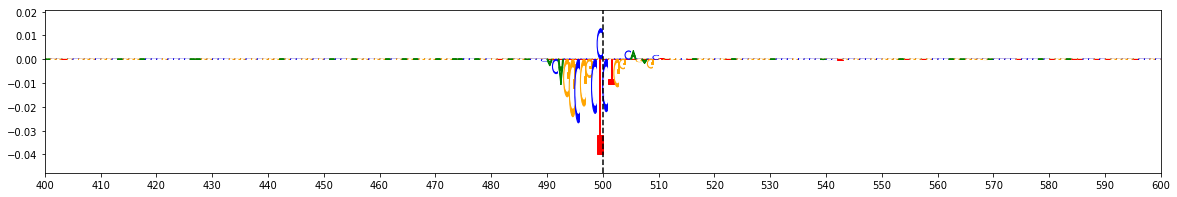


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs62060787   ||    chr17 : 46059436 - 46059437   ||    Locus: 165   ||    IDR Peak: False

GWAS:
23andme_PD_hg38 		  2.51E-22

Coloc:  True

Effect Allele: T   ||  Explain Score: 0.5762   ||  Center / 200bp: 0.497
Effect Sequence: GGCCAACATTGTGAAACCCC


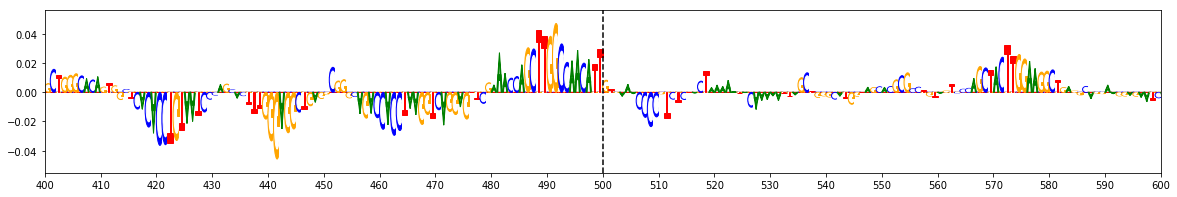

Noneffect Allele: G   ||  Explain Score: 0.3686   ||  Center / 200bp: 0.3876
Noneffect Sequence: GGCCAACATGGTGAAACCCC


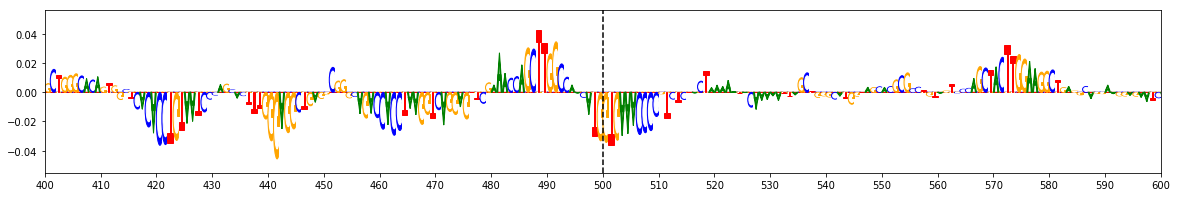

Allele Ratio : 1.5635   ||   Allele Difference : 0.5008  ||  ISM Score : 0.7939  ||  deltaSVM Score : 4.5819


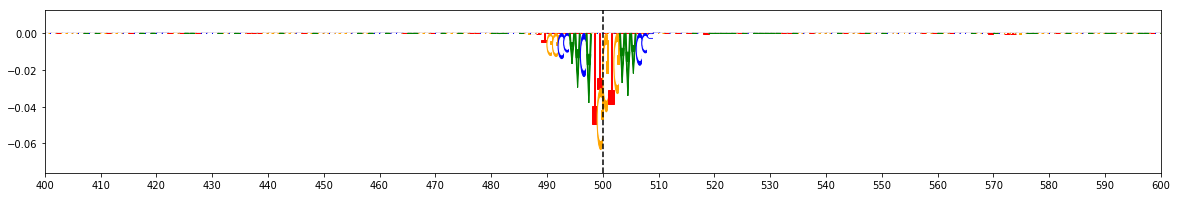


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs150820726   ||    chr19 : 44723890 - 44723891   ||    Locus: 219   ||    IDR Peak: True

GWAS:
Alzheimers_Jansen_2018 		  1.02E-11

Coloc:  True

Effect Allele: T   ||  Explain Score: 0.774   ||  Center / 200bp: 0.5415
Effect Sequence: AGCTGCCACTTGCAGGGTGA


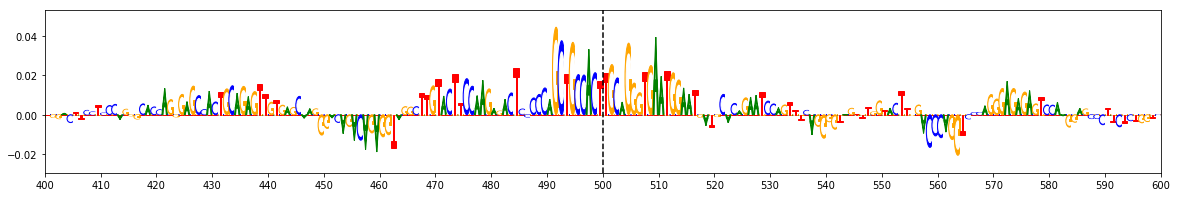

Noneffect Allele: A   ||  Explain Score: 0.5432   ||  Center / 200bp: 0.4527
Noneffect Sequence: AGCTGCCACATGCAGGGTGA


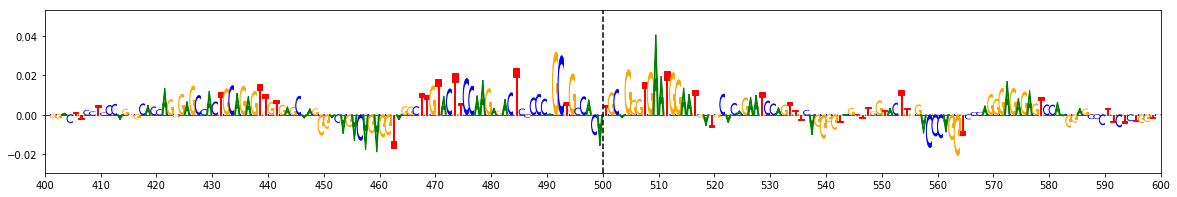

Allele Ratio : 1.4249   ||   Allele Difference : 0.2584  ||  ISM Score : 0.4057  ||  deltaSVM Score : 2.3496


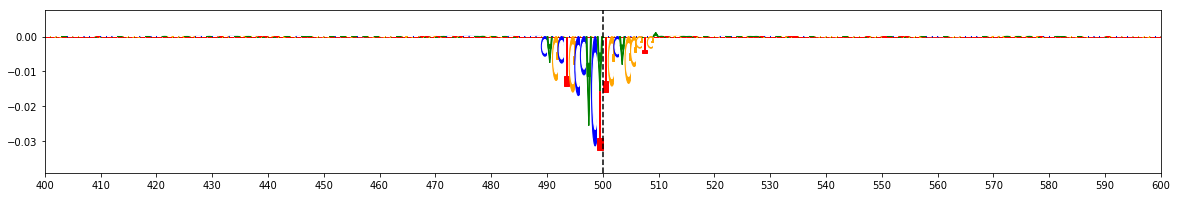


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs62064665   ||    chr17 : 46004160 - 46004161   ||    Locus: 162   ||    IDR Peak: True

GWAS:
23andme_PD_hg38 		  2.11E-22

Coloc:  True

Effect Allele: T   ||  Explain Score: 2.1647   ||  Center / 200bp: 0.6532
Effect Sequence: CAGGCCAAGTCTGGGCCAGC


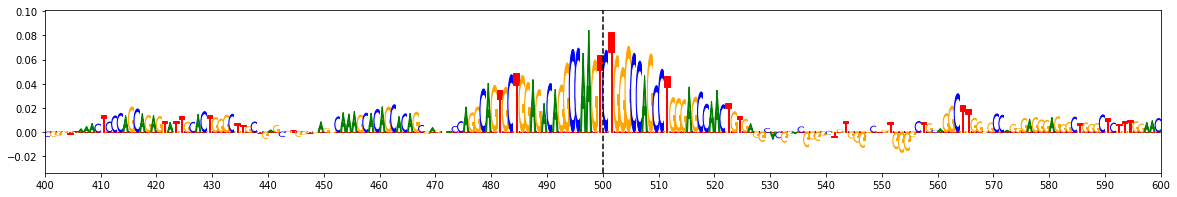

Noneffect Allele: C   ||  Explain Score: 1.892   ||  Center / 200bp: 0.6231
Noneffect Sequence: CAGGCCAAGCCTGGGCCAGC


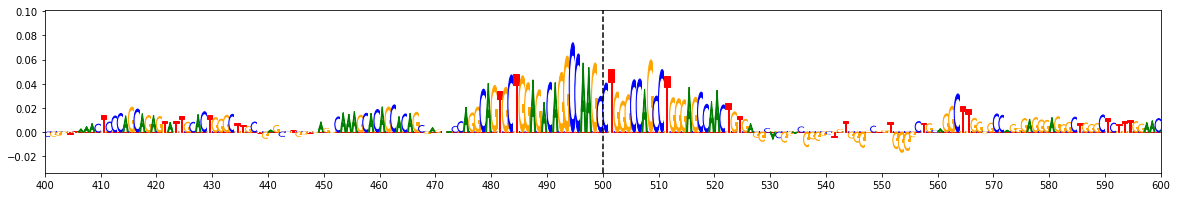

Allele Ratio : 1.1441   ||   Allele Difference : 0.2727  ||  ISM Score : 0.4413  ||  deltaSVM Score : 2.3891


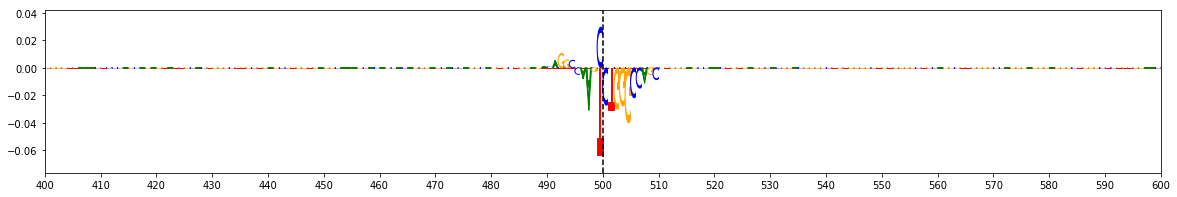


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs78826239   ||    chr17 : 46213483 - 46213484   ||    Locus: 178   ||    IDR Peak: True

GWAS:
23andme_PD_hg38 		  1.10E-18

Coloc:  True

Effect Allele: T   ||  Explain Score: 0.5203   ||  Center / 200bp: 0.7092
Effect Sequence: TTTTTTTTTTTTTTTAGTAG


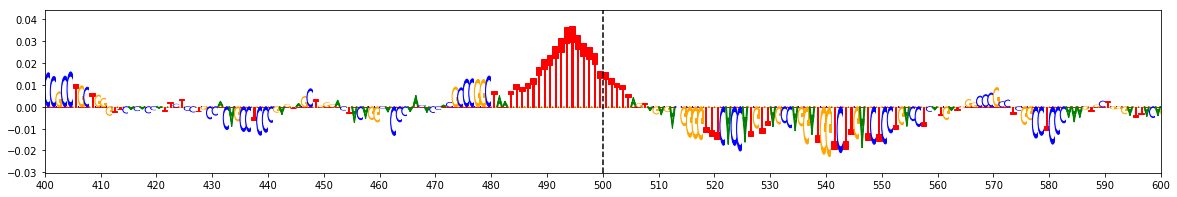

Noneffect Allele: A   ||  Explain Score: 0.4966   ||  Center / 200bp: 0.6457
Noneffect Sequence: TTTTTTTTTATTTTTAGTAG


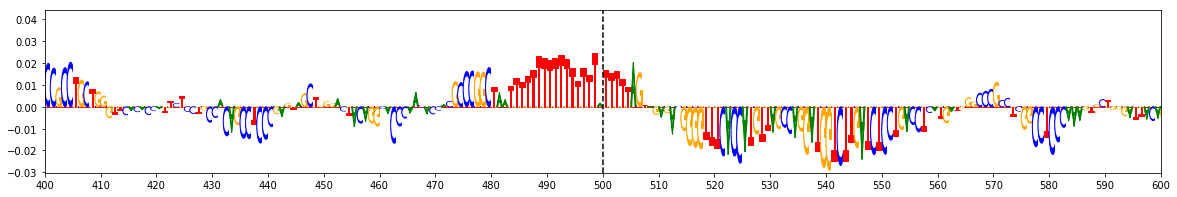

Allele Ratio : 1.0477   ||   Allele Difference : 0.0721  ||  ISM Score : 0.0421  ||  deltaSVM Score : 8.1628


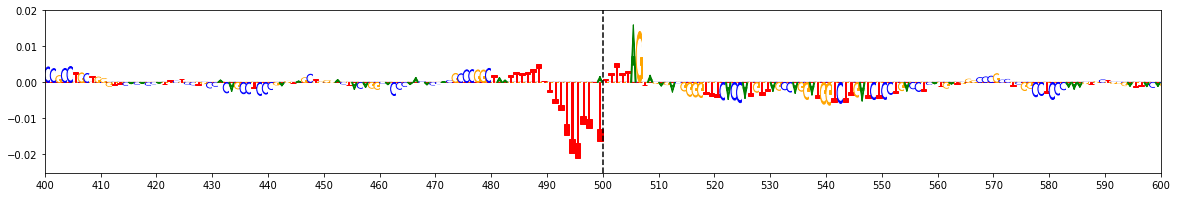


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------




In [8]:
for idx in pos_snps.index[:20]:
    #for idx in [60]:
    print('RSID:', pos_snps.at[idx, 'rsid'],
          '  ||   ', pos_snps.at[idx, 'chr'], ':', pos_snps.at[idx, 'start'], '-', pos_snps.at[idx, 'end'],
          '  ||   ', 'Locus:', idx, '  ||   ', 'IDR Peak:', pos_snps.at[idx, 'idr_peak'])
    
    print()
    
    print('GWAS:')
    
    for i in pos_snps.at[idx, 'all_gwas']:
        entry = i.split(':')
        if 'Lambert' in entry[0] or 'Pankratz' in entry[0] or 'Chang' in entry[0]:
            print(entry[0], '\t', entry[1])
        else:
            print(entry[0], '\t\t', entry[1])
    
    print()
        
    print("Coloc: ", pos_snps.at[idx, 'coloc'])
    
    print()
    
    print('Effect Allele:', pos_snps.at[idx, 'effect'], '  ||  Explain Score:', round(pos_snps.at[idx, 'effect_center'], 4), '  ||  Center / 200bp:', round(pos_snps.at[idx, 'effect_ratio'], 4))
    print('Effect Sequence:', effect_seqs[idx][490:510])
    
    ylim = plot_weights(merged_effect_scores[idx], subticks_frequency=10, xlim=(400,600))

    print('Noneffect Allele:', pos_snps.at[idx, 'noneffect'], '  ||  Explain Score:', round(pos_snps.at[idx, 'noneffect_center'], 4), '  ||  Center / 200bp:', round(pos_snps.at[idx, 'noneffect_ratio'], 4))
    print('Noneffect Sequence:', noneffect_seqs[idx][490:510])
    
    a = plot_weights(merged_noneffect_scores[idx], subticks_frequency=10, ylim=ylim, xlim=(400,600))
    
    print('Allele Ratio :', round(pos_snps.at[idx, 'allele_ratio'], 4), '  ||   Allele Difference :', round(pos_snps.at[idx, 'allele_diff'], 4),
          ' ||  ISM Score :', round(pos_snps.at[idx, 'ism_score'], 4), ' ||  deltaSVM Score :', round(pos_snps.at[idx, 'delta_score'], 4))
    
    a = plot_weights(merged_noneffect_scores[idx] - merged_effect_scores[idx], subticks_frequency=10, xlim=(400,600))
    
    print()
    print('-'*80)
    print('-'*80)
    print()
    print()